# Packages and Functions

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy import stats
from scipy.spatial import Voronoi, voronoi_plot_2d
from pykrige.ok import OrdinaryKriging

import geopandas as gpd
import rasterio
import rasterio.mask
import geoplot as gplt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
from shapely.ops import nearest_points
from rasterio.transform import Affine
from rasterio.plot import show

from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from census import Census
from us import states

from io import StringIO

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Python and ML Learnings with AI COE\\Spatial Programming & Remote Sensing'

# Attributes & Indexing for Vector Data

<p align ='center'>
    <img src = 'https://pygis.io/_images/dataframe.svg'>
</p>

Each `GeoSeries` can contain any geometry type (e.g. points, lines, polygon) and has a `GeoSeries.crs` attribute, which stores information on the projection (CRS stands for Coordinate Reference System). Therefore, each `GeoSeries` in a `GeoDataFrame` can be in a different projection, allowing you to have, for example, multiple versions of the same geometry, just in a different CRS.

## Create New Attributes

One of the most basic operations is creating new attributes. Let’s say for instance we want to look at the world population in millions. We can start with an existing column of data `pop_est`. Let’s start by looking at the column names:

In [145]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

We can then do basic operations on the basis of column names. Here we create a new column `m_pop_est`:

In [146]:
world['m_pop_est'] = world['pop_est'] / 1e6
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry   m_pop_est  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    0.889953  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   58.005463  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...    0.603253  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   37.589262  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  328.239523

## Indexing and Selecting Data

GeoPandas inherits the standard pandas methods for indexing/selecting data. This includes label based indexing with .loc and integer position based indexing with .iloc, which apply to both GeoSeries and GeoDataFrame objects.

### Selection by Index Position

Pandas provides a suite of methods in order to get purely integer based indexing. The semantics follow closely Python and NumPy slicing. These are 0-based indexing. When slicing, the start bound is included, while the upper bound is excluded. For instance `name = 'fudge'` with `name[0:3]` returns `'fud'`, where f is at 0 and g is at the 3 position with the upper bound excluded.

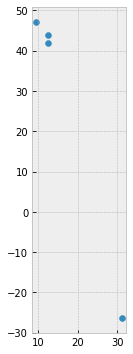

In [147]:
plt.style.use('bmh')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
northern_world = world.iloc[0:4]
northern_world.plot(figsize = (12, 6))
plt.show()

Object selection has had a number of user-requested additions in order to support more explicit location based indexing.

Getting values from an object with multi-axes selection uses the following notation (using `.loc` as an example, but the following applies to `.iloc` as well). Any of the axes accessors may be the null slice `:`. Axes left out of the specification are assumed to be `:`, e.g. `p.loc['a']` is equivalent to `p.loc['a', :, :]`.

| Object Type | Indexers |
| --- | --- |
| Series | `s.loc[indexer]` |
| DataFrame | `df.loc[row_indexer, column_indexer]` |

### Subset Points by Location

In addition to the standard pandas methods, GeoPandas also provides coordinate based indexing with the cx indexer, which slices using a bounding box. Geometries in the `GeoSeries` or `GeoDataFrame` that intersect the bounding box will be returned.

Using the `world` dataset, we can use this functionality to quickly select all cities in the northern and southern hemisphere using a `_CoordinateIndexer` using `.cx`. `.cx` allows you to quickly access the table’s geometry, where indexing reflects `[x, y]` or `[lon, lat]`. Here we will query points above and below 0 degrees latitude:

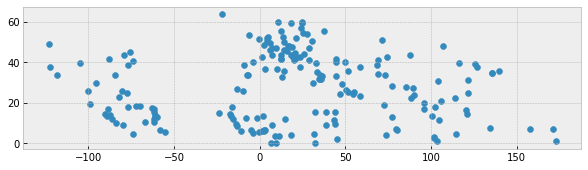

In [148]:
northern_world = world.cx[:, 0:] # subsets all rows above 0 with a slice
northern_world.plot(figsize = (10, 5))
plt.show()

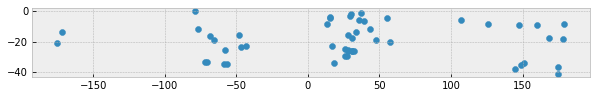

In [149]:
southern_world = world.cx[:, :0] # subsets all rows below 0 with a slice
southern_world.plot(figsize = (10, 5))
plt.show()

# Proximity Analysis - Buffers, Nearest Neighbor

## Buffer Analysis

In [150]:
data = """
ID,X,Y
1,  -87.789,  41.976
1,  -87.482,  41.677
2,  -87.599,  41.908
2,  -87.598,  41.708
2,  -87.643,  41.675
"""

# Use StringIO to read in text chunk
df = pd.read_table(StringIO(data), sep = ',')
df.head()

ID       X       Y
0   1 -87.789  41.976
1   1 -87.482  41.677
2   2 -87.599  41.908
3   2 -87.598  41.708
4   2 -87.643  41.675

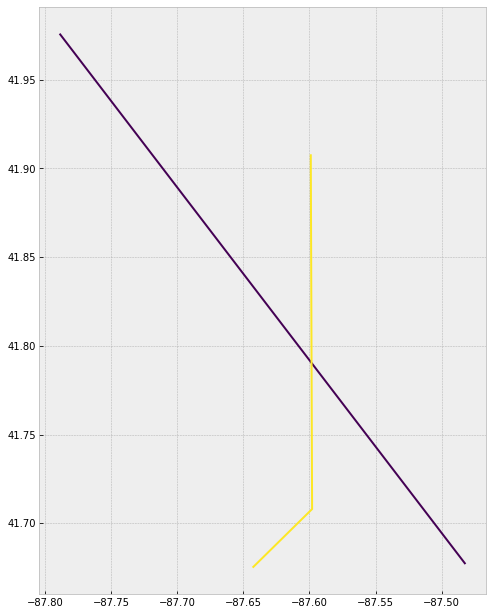

In [151]:
# Zip the coordinates into a point object and convert into a GeoDataFrame
points = [Point(xy) for xy in zip (df.X, df.Y)]
points = gpd.GeoDataFrame(df, geometry = points, crs = 'EPSG:4326')

# Create line for each ID
lines = points.groupby(['ID'])['geometry'].apply(lambda x: LineString(x.tolist()))
lines = gpd.GeoDataFrame(lines, geometry = 'geometry', crs = 'EPSG:4326')
lines.reset_index(inplace = True)

lines.plot(column = 'ID', figsize = (8, 12))
plt.show()

**NEVER do distance analysis with unprojected data (e.g. lat lon)**. Distances are best not measured in degrees! Instead use `.to_crs()` to convert it to a projected coordinate system with a linear unit in feet or meters etc.

Although it is not clearly stated the distance parameter is measured in the linear unit of the projection. So before we get started we need to make sure to use `to_crs()` to convert to a projected coordinate system.

In [152]:
# Plot county outline and add wells to axis (ax)
lines = lines.to_crs(3857)

# Check the linear unit name in `unit_name`
print(lines.crs.axis_info)

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre), Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]


Starting from two lines, we can now play around with the buffer function.

0    POLYGON ((-9737657.488 5113325.388, -9737601.7...
1    POLYGON ((-9750364.761 5117342.850, -9750369.3...
dtype: geometry


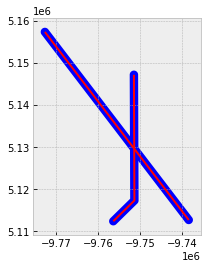

In [153]:
buf = lines.buffer(distance = 1000)
bp = buf.plot()
lines.plot(ax = bp, color = 'red')
print(buf)

| Attribute | Value |
| --- | --- |
| round | 1 |
| flat | 2 |
| square | 3 |

Buffer caps can be different shapes. We can also create left or right side buffers. Use negative distances for left, and positive distances for right.

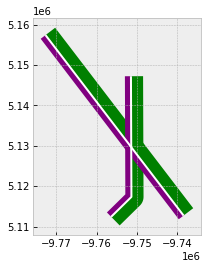

In [154]:
buf_right = lines.buffer(distance = 3000, single_sided = True)
bp = buf_right.plot(color = 'green')

buf_left = lines.buffer(distance = -1500, single_sided = True)
buf_left.plot(ax = bp, color = 'purple')
lines.plot(ax = bp, color = 'white')
plt.show()

## Nearest Neighbor Analysis

One commonly used GIS task is to be able to find the nearest neighbor. For instance, you might have a single Point object representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *“which of the stops is closest one to my home?”* This is a typical nearest neighbor analysis, where the aim is to find the closest geometry to another geometry. 1

In Python this kind of analysis can be done with shapely function called `nearest_points()` that returns a tuple of the nearest points in the input geometries.

### Nearest point using Shapely

Let’s start by testing how we can find the nearest Point using the `nearest_points` function of Shapely.

Let’s create an origin Point and a few destination Points and find out the closest destination. To find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [155]:
orig = Point(1, 1.67)
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)

destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


Now we can see that all the destinations points are represented as a single MultiPoint object. Now we can find out the nearest destination point by using `nearest_points()` function.

In [156]:
nearest_geoms = nearest_points(orig, destinations)
original_point, nearest_destination = nearest_geoms

print(nearest_geoms)
print('Coordinates of original point: ', original_point)
print('Coordinates of closest destination point: ', nearest_destination)

(<shapely.geometry.point.Point object at 0x0000021DBE254070>, <shapely.geometry.point.Point object at 0x0000021DBE254F70>)
Coordinates of original point:  POINT (1 1.67)
Coordinates of closest destination point:  POINT (0 1.45)


As you can see the `nearest_points` function returns a tuple of geometries where the first item is the geometry of our origin point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45).

This is the basic logic how we can find the nearest point from a set of points.

### Nearest points using Geopandas

Of course, the previous example is not really useful yet. Hence, let's investigate how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. In this example, we will recreate the previous example but use geopandas, however this data could come from any shapefile.

First we need to create a function that takes advantage of the previous function but is tailored to work with two GeoDataFrames.

In [157]:
def _nearest(row, df1, df2, geom1 = 'geometry', geom2 = 'geometry', df2_column = None):
    """
    Find the nearest point and return the corresponding value from the specified column.
    """

    # Create object usable by Shapely
    geom_union = df2.unary_union

    # Find the geometry that is closest
    nearest = df2[geom2] == nearest_points(row[geom1], geom_union)[1]

    # Get the corresponding value from df2 (matching is based on the geometry)
    if df2_column is None:
        value = df2[nearest].index[0]
    else:
        value = df2[nearest][df2_column].values[0]
    return value

def nearest(df1, df2, geom1_col = 'geometry', geom2_col = 'geometry', df2_column = None):
    """Find the nearest point and return the corresponding value from the specified column.

    Args:
        df1 (geopandas.GeoDataFrame): Origin points
        df2 (geopandas.GeoDataFrame): Destination points
        geom1_col (str, optional): Name of column holding coordinate geometry. Defaults to 'geometry'.
        geom2_col (str, optional): Name of column holding coordinate geometry. Defaults to 'geometry'.
        df2_column (str, optional): Column name to return from df2. Defaults to None.
    """

    df1['nearest_id'] = df1.apply(_nearest, df1 = df1, df2 = df2, geom1 = geom1_col, geom2 = geom2_col,
                                    df2_column = df2_column, axis = 1)
    return df1

In [158]:
# Generate origin and destination points as geodataframe
orig = {
    'name': ['Origin 1', 'Origin 2'],
    'geometry': [Point(-77.3, 38.94), Point(-77.41, 39.93)]
}
orig = gpd.GeoDataFrame(orig, crs = 'EPSG:4326')
print(orig)

dest = {
    'name': ['Baltimore', 'Washington', 'Fredrick'],
    'geometry': [Point(-76.61, 39.29), Point(-77.04, 38.91), Point(-77.40, 39.41)]
}
dest = gpd.GeoDataFrame(dest, crs = 'EPSG:4326')
print(dest)

       name                    geometry
0  Origin 1  POINT (-77.30000 38.94000)
1  Origin 2  POINT (-77.41000 39.93000)
         name                    geometry
0   Baltimore  POINT (-76.61000 39.29000)
1  Washington  POINT (-77.04000 38.91000)
2    Fredrick  POINT (-77.40000 39.41000)


Now, we are ready to use our function and find closest Points (taking the value from the id column) from df2 to df1 centroids.

In [159]:
nearest = nearest(df1 = orig, df2 = dest, df2_column = 'name')
nearest

name                    geometry  nearest_id
0  Origin 1  POINT (-77.30000 38.94000)  Washington
1  Origin 2  POINT (-77.41000 39.93000)    Fredrick

That’s it! Now we found the closest point for each centroid and got the `index` value or column name from our addresses into the `df1` GeoDataFrame.

Note: If you want to do nearest neighbor analysis with polygons, you can simply use the centroid. If you have a geopandas polygon called poly, run `poly[‘centroid’] = poly.centroid` to store the centroid values in the attribute table.

# Merge Data & Dissolve Polygons

Dataframes are widely used in Python for manipulating data. Recall that a dataframe is essentially an Excel spreadsheet (a 2-D table of rows and columns); in fact, many of the functions that you might use in Excel can often be replicated when working with dataframes in Python!

This chapter will introduce you to some of the basic operations that you can perform on dataframes. We will use these basic operations in order to calculate and map poverty rates in the Commonwealth of Virginia. We will pull data from the US Census Bureau’s American Community Survey (ACS) 2019.

## Accessing Data

### Import census data

Let’s begin by accessing and importing census data. Importing census data into Python requires a Census API key. A key can be obtained from [Census API Key](http://api.census.gov/data/key_signup.html). **It will provide you with a unique 40 digit text string**. Please keep track of this number. Store it in a safe place.

In [160]:
# Set API key
c = Census('7421e9e21dbc8532225314c791dc75930c17011a')

With the Census API key set, we will access the census data at the tract level for the Commonwealth of Virginia from the 2019 ACS, specifically the **ratio of income to poverty in the past 12 months** (`C17002_001E`, total; `C17002_002E`, < 0.50; and `C17002_003E`, 0.50 - 0.99) variables and the **total population** (`B01003_001E`) variable. 

The `census` package provides us with some easy convenience methods that allow us to obtain data for a wide variety of geographies. The FIPS code for Virginia is 51, but if needed, we can also use the `us` library to help us figure out the relevant FIPS code.

In [161]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
    # C17002_001E: count of ratio of income to poverty in the past 12 months (total)
    # C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
    # C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
    # B01003_001E: total population
va_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                    state_fips = states.VA.fips,
                                    county_fips = '*',
                                    tract = '*',
                                    year = 2019)

# Create a dataframe from the census data
va_df = pd.DataFrame(va_census)
print(va_df.shape)
va_df.head()

(1907, 8)


NAME  C17002_001E  C17002_002E  \
0     Census Tract 202, Fluvanna County, Virginia       4804.0        197.0   
1  Census Tract 4607.02, Fairfax County, Virginia       4578.0         58.0   
2  Census Tract 4612.01, Fairfax County, Virginia       4685.0          0.0   
3  Census Tract 4612.02, Fairfax County, Virginia       6403.0        258.0   
4  Census Tract 4616.01, Fairfax County, Virginia       7985.0        349.0   

   C17002_003E  B01003_001E state county   tract  
0        146.0       4863.0    51    065  020200  
1         30.0       4578.0    51    059  460702  
2         17.0       4685.0    51    059  461201  
3         45.0       6403.0    51    059  461202  
4        456.0       8001.0    51    059  461601

### Import Shapefile

Let’s also read into Python a shapefile of the Virginia census tracts and reproject it to the UTM Zone 17N projection. (This shapefile can be downloaded on the Census Bureau’s website on the Cartographic Boundary Files page or the TIGER/Line Shapefiles page.)

In [162]:
# Access shapefile of Virginia census tracts
va_tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_51_tract.zip')

# Reproject shapefile to UTM Zone 17N
va_tract = va_tract.to_crs(epsg = 32617)

# Check shapefile projection
print('The shapefile projection is {}'.format(va_tract.crs))

print('Shape: ', va_tract.shape)
va_tract.head()

The shapefile projection is EPSG:32617
Shape:  (1907, 13)


STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      51      700  032132  51700032132  321.32  Census Tract 321.32  G5020   
1      51      700  032226  51700032226  322.26  Census Tract 322.26  G5020   
2      51      087  200600  51087200600    2006    Census Tract 2006  G5020   
3      51      087  200700  51087200700    2007    Census Tract 2007  G5020   
4      51      143  011001  51143011001  110.01  Census Tract 110.01  G5020   

  FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S    2552457       0  +37.1475176  -076.5212499   
1        S    3478916  165945  +37.1625163  -076.5527816   
2        S    2440454    3537  +37.6118939  -077.4784858   
3        S    3004440   61338  +37.6106740  -077.4605089   
4        S  127726451  167026  +36.6590883  -079.5925411   

                                            geometry  
0  POLYGON ((897173.396 4119897.287, 897174.015 4...  
1  POLYGON ((893469.801 4123469.592, 893541.960 4...  
2  POLYGON ((809921.909 4169256.113, 809931.638 4...  
3  POLYGON ((811247.614 4169137.138, 811279.544 4...  
4  POLYGON ((617144.053 4056835.931, 617146.130 4...

By printing the shapefile, we can see that the shapefile also has 1907 rows (1907 tracts). This number matches with the number of census records that we have on file. Perfect!

Not so fast, though. We have a potential problem: We have the census data, and we have the shapefile of census tracts that correspond with that data, but they are stored in two separate variables (`va_df` and `va_tract` respectively)! That makes it a bit difficult to map since these two separate datasets aren’t connected to each other.

## Performing DataFrame Operations

### Create new column from old columns to get combined FIPS code

To solve this problem, we can join the two dataframes together via a field or column that is common to both dataframes, which is referred to as a key.

Looking at the two datasets above, it appears that the `GEOID` column from `va_tract` and the `state`, `county`, and `tract` columns combined from `va_df` could serve as the unique key for joining these two dataframes together. In their current forms, this join will not be successful, as we’ll need to merge the `state`, `county`, and `tract` columns from `va_df` together to make it parallel to the `GEOID` column from `va_tract`. We can simply add the columns together, much like math or the basic operators in Python, and assign the “sum” to a new column.

To create a new column–or call an existing column in a dataframe–we can use indexing with `[]` and the column name (string).

In [163]:
# Combine state, county, and tract columns together to create a new string and assign a new column
va_df['GEOID'] = va_df['state'] + va_df['county'] + va_df['tract']

va_df.head()

NAME  C17002_001E  C17002_002E  \
0     Census Tract 202, Fluvanna County, Virginia       4804.0        197.0   
1  Census Tract 4607.02, Fairfax County, Virginia       4578.0         58.0   
2  Census Tract 4612.01, Fairfax County, Virginia       4685.0          0.0   
3  Census Tract 4612.02, Fairfax County, Virginia       6403.0        258.0   
4  Census Tract 4616.01, Fairfax County, Virginia       7985.0        349.0   

   C17002_003E  B01003_001E state county   tract        GEOID  
0        146.0       4863.0    51    065  020200  51065020200  
1         30.0       4578.0    51    059  460702  51059460702  
2         17.0       4685.0    51    059  461201  51059461201  
3         45.0       6403.0    51    059  461202  51059461202  
4        456.0       8001.0    51    059  461601  51059461601

### Remove columns that are no longer needed

To reduce clutter, we can delete the `state`, `county`, and `tract` columns from `va_df` since we don’t need them anymore. Remember that when we want to modify a dataframe, we must assign the modified dataframe back to the original variable (or a new one, if preferred). Otherwise, any modifications won’t be saved. An alternative to assigning the dataframe back to the variable is to simply pass `inplace = True`. 

In [164]:
# Remove columns
va_df = va_df.drop(['state', 'county', 'tract'], axis = 1)
va_df.head()

NAME  C17002_001E  C17002_002E  \
0     Census Tract 202, Fluvanna County, Virginia       4804.0        197.0   
1  Census Tract 4607.02, Fairfax County, Virginia       4578.0         58.0   
2  Census Tract 4612.01, Fairfax County, Virginia       4685.0          0.0   
3  Census Tract 4612.02, Fairfax County, Virginia       6403.0        258.0   
4  Census Tract 4616.01, Fairfax County, Virginia       7985.0        349.0   

   C17002_003E  B01003_001E        GEOID  
0        146.0       4863.0  51065020200  
1         30.0       4578.0  51059460702  
2         17.0       4685.0  51059461201  
3         45.0       6403.0  51059461202  
4        456.0       8001.0  51059461601

### Check column data types

The key in both dataframe must be of the same data type. Let’s check the data type of the `GEOID` columns in both dataframes. If they aren’t the same, we will have to change the data type of columns to make them the same.

In [165]:
# Check column data types for census data
print('Column data types for census data:\n{}'.format(va_df.dtypes))

# Check column data types for census shapefile
print('\nColumn data types for census shapefile:\n{}'.format(va_tract.dtypes))

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


Looks like the `GEOID` columns data types are the same!

### Merge dataframes

Now, we are ready to merge the two dataframes together, using the `GEOID` columns as the primary key. We can use the `merge` method in GeoPandas called on the `va_tract` shapefile dataset.

In [166]:
# Join the attributes of the dataframes together
va_merge = va_tract.merge(va_df, on = 'GEOID')

print('Shape: ', va_merge.shape)
va_merge.head()

Shape:  (1907, 18)


STATEFP COUNTYFP TRACTCE        GEOID  NAME_x             NAMELSAD  MTFCC  \
0      51      700  032132  51700032132  321.32  Census Tract 321.32  G5020   
1      51      700  032226  51700032226  322.26  Census Tract 322.26  G5020   
2      51      087  200600  51087200600    2006    Census Tract 2006  G5020   
3      51      087  200700  51087200700    2007    Census Tract 2007  G5020   
4      51      143  011001  51143011001  110.01  Census Tract 110.01  G5020   

  FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S    2552457       0  +37.1475176  -076.5212499   
1        S    3478916  165945  +37.1625163  -076.5527816   
2        S    2440454    3537  +37.6118939  -077.4784858   
3        S    3004440   61338  +37.6106740  -077.4605089   
4        S  127726451  167026  +36.6590883  -079.5925411   

                                            geometry  \
0  POLYGON ((897173.396 4119897.287, 897174.015 4...   
1  POLYGON ((893469.801 4123469.592, 893541.960 4...   
2  POLYGON ((809921.909 4169256.113, 809931.638 4...   
3  POLYGON ((811247.614 4169137.138, 811279.544 4...   
4  POLYGON ((617144.053 4056835.931, 617146.130 4...   

                                              NAME_y  C17002_001E  \
0   Census Tract 321.32, Newport News city, Virginia       4997.0   
1   Census Tract 322.26, Newport News city, Virginia       4483.0   
2        Census Tract 2006, Henrico County, Virginia       4716.0   
3        Census Tract 2007, Henrico County, Virginia       3533.0   
4  Census Tract 110.01, Pittsylvania County, Virg...       4041.0   

   C17002_002E  C17002_003E  B01003_001E  
0        208.0        182.0       4997.0  
1        625.0        739.0       4490.0  
2        213.0        112.0       4731.0  
3        510.0        332.0       3697.0  
4        155.0        275.0       4048.0

Success! We still have 1907 rows, which means that all rows (or most of them) were successfully matched! Notice how the census data has been added on after the shapefile data in the dataframe. Some additional notes about joining dataframes:
- The columns for the key do not need to have the same name.
- For this join, we had a **one-to-one relationship**, meaning one attribute in one dataframe matched to one (and only one) attribute in the other dataframe. Joins with a many-to-one, one-to-many, or many-to-many relationship are also possible, but in some cases, they require some special considerations.

### Subset dataframe

Now that we merged the dataframes together, we can further clean up the dataframe and remove columns that are not needed. Instead of using the `drop` method, we can simply select the columns we want to keep and create a new dataframe with those selected columns.

In [167]:
# Create new dataframe from selected columns
va_poverty_tract = va_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

print('Shape: ', va_poverty_tract.shape)
va_poverty_tract.head()

Shape:  (1907, 9)


STATEFP COUNTYFP TRACTCE        GEOID  \
0      51      700  032132  51700032132   
1      51      700  032226  51700032226   
2      51      087  200600  51087200600   
3      51      087  200700  51087200700   
4      51      143  011001  51143011001   

                                            geometry  C17002_001E  \
0  POLYGON ((897173.396 4119897.287, 897174.015 4...       4997.0   
1  POLYGON ((893469.801 4123469.592, 893541.960 4...       4483.0   
2  POLYGON ((809921.909 4169256.113, 809931.638 4...       4716.0   
3  POLYGON ((811247.614 4169137.138, 811279.544 4...       3533.0   
4  POLYGON ((617144.053 4056835.931, 617146.130 4...       4041.0   

   C17002_002E  C17002_003E  B01003_001E  
0        208.0        182.0       4997.0  
1        625.0        739.0       4490.0  
2        213.0        112.0       4731.0  
3        510.0        332.0       3697.0  
4        155.0        275.0       4048.0

### Dissolve geometries and get summarized statistics to get poverty statistics at the county level

Next, we will group all the census tracts within the same county (`COUNTYFP`) and aggregate the poverty and population values for those tracts within the same county. We can use the `dissolve` function in GeoPandas, which is the spatial version of `groupby` in pandas. We use `dissolve` instead of `groupby` because the former **also groups and merges all the geometries (in this case, census tracts) within a given group** (in this case, counties).

In [168]:
# Dissolve and group the census tracts within each county and aggregate all values together
va_poverty_county = va_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

print('Shape: ', va_poverty_county.shape)
va_poverty_county.head()

Shape:  (133, 5)


geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((971900.699 4160101.039, 971813.440 4...      32325.0   
003       POLYGON ((734957.170 4207640.282, 734931.151 4...     100293.0   
005       POLYGON ((597839.309 4194522.271, 597868.835 4...      14830.0   
007       POLYGON ((778844.291 4138890.927, 778844.594 4...      12861.0   
009       POLYGON ((669198.998 4140588.797, 669197.293 4...      30994.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001            2352.0       3789.0      32673.0  
003            5034.0       4108.0     107405.0  
005            1700.0       1225.0      15157.0  
007             526.0        849.0      12953.0  
009            2137.0       2190.0      31775.0

### Perform column math to get poverty rates

We can estimate the poverty rate by dividing the sum of `C17002_002E` (ratio of income to poverty in the past 12 months, < 0.50) and `C17002_003E` (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by `B01003_001E` (total population).

Side note: Notice that `C17002_001E` (ratio of income to poverty in the past 12 months, total), which theoretically should count everyone, does not exactly match up with `B01003_001E` (total population). We’ll disregard this for now since the difference is not too significant.

In [169]:
# Get poverty rate and store values in new column
va_poverty_county['Poverty_Rate'] = (va_poverty_county['C17002_002E'] + va_poverty_county['C17002_003E']) / va_poverty_county['B01003_001E'] * 100

va_poverty_county.head()

geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((971900.699 4160101.039, 971813.440 4...      32325.0   
003       POLYGON ((734957.170 4207640.282, 734931.151 4...     100293.0   
005       POLYGON ((597839.309 4194522.271, 597868.835 4...      14830.0   
007       POLYGON ((778844.291 4138890.927, 778844.594 4...      12861.0   
009       POLYGON ((669198.998 4140588.797, 669197.293 4...      30994.0   

          C17002_002E  C17002_003E  B01003_001E  Poverty_Rate  
COUNTYFP                                                       
001            2352.0       3789.0      32673.0     18.795336  
003            5034.0       4108.0     107405.0      8.511708  
005            1700.0       1225.0      15157.0     19.298014  
007             526.0        849.0      12953.0     10.615301  
009            2137.0       2190.0      31775.0     13.617624

## Plotting Results

Finally, since we have the spatial component connected to our census data, we can plot the results!

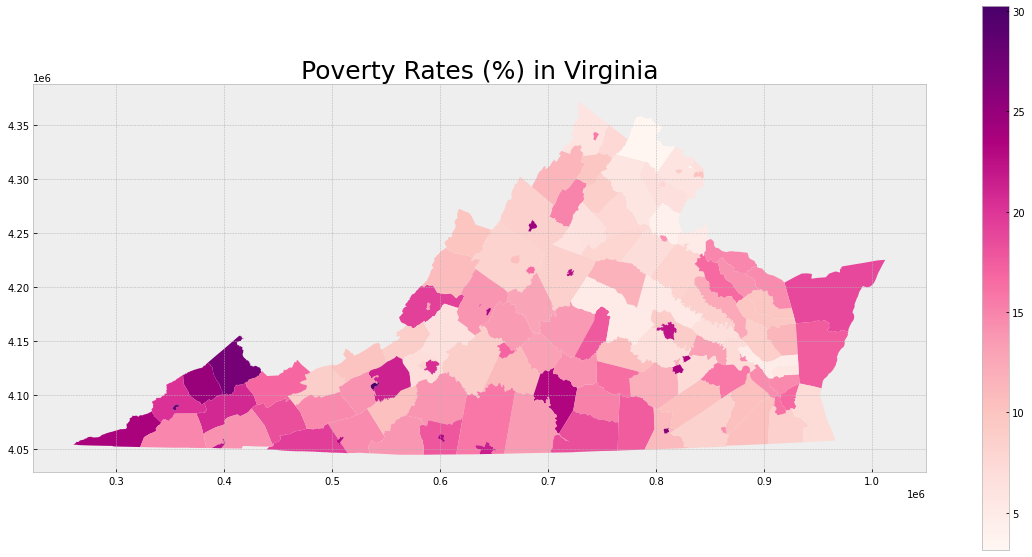

In [170]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

va_poverty_county.plot(column = 'Poverty_Rate',
                        ax = ax,
                        cmap = 'RdPu',
                        legend = True)

plt.style.use('bmh')
ax.set_title('Poverty Rates (%) in Virginia', fontdict = {'fontsize': '25', 'fontweight': '3'})
plt.show()

# Extracting Spatial Data

Subsetting and extracting data is useful when we want to select or analyze a portion of the dataset based on a feature’s location, attribute, or its spatial relationship to another dataset.

In this chapter, we will explore three ways that data from a GeoDataFrame can be subsetted and extracted: clip, select location by attribute, and select by location.

## Setup

We will utilize shapefiles of San Francisco Bay Area county boundaries and wells within the Bay Area and the surrounding 50 km. 

We will also create a rectangle over a part of the Bay Area. We have identified coordinates to use for this rectangle, but you can also use bbox finder to generate custom bounding boxes and obtain their coordinates.

We’ll define some functions to make displaying and mapping our results a bit easier.

In [171]:
# Load data

# County boundaries
counties = gpd.read_file(os.getcwd() + '/data/static/sf_bay_counties/sf_bay_counties.shp')

# Well locations
wells = gpd.read_file(os.getcwd() + '/data/static/sf_bay_wells_50km/sf_bay_wells_50km.shp')

# Reproject data to NAD83 (HARN) / California Zone 3
proj = 2768
counties = counties.to_crs(proj)
wells = wells.to_crs(proj)

# Create list of coordinate pairs
coordinates = [[1790787, 736108], [1929652, 736108], [1929652, 598414], [1790787, 598414]]

# Create a Shapely polygon from coordinate-tuple list
poly_shapely = Polygon(coordinates)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {
    'Attribute': ['name1'],
    'geometry': poly_shapely
}

# Convert shapely object to a GeoDataFrame
poly = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = 'EPSG:2768')

def display_table(table_name, attribute_table):
    '''Display the first and last five rows of attribute table.'''

    # Print title
    print("Attribute Table: {}".format(table_name))

    # Print number of rows and columns
    print("\nTable shape (rows, columns): {}".format(attribute_table.shape))

    # Display first two rows of attribute table
    print("\nFirst two rows:")
    display(attribute_table.head(2))

    # Display last two rows of attribute table
    print("\nLast two rows:")
    display(attribute_table.tail(2))


def plot_df(result_name, result_df, result_geom_type, area = None):
    '''Plot the result on a map and add the outlines of the original shapefiles.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot data depending on vector type
    # For points
    if result_geom_type == "point":

        # Plot data
        counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
        wells.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 3)
        result_df.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)

    # For polygons
    else:

        # Plot overlay data
        result_df.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

        # Plot outlines of original shapefiles
        counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')

    # Add additional outlined boundary if specified
    if area is not None:

        # Plot data
        area.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', linewidth = 3)

    # Else, pass
    else:
        pass

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title(result_name, fontdict = {'fontsize': '15', 'fontweight' : '3'})

Let's take a look at what our input data looks like.

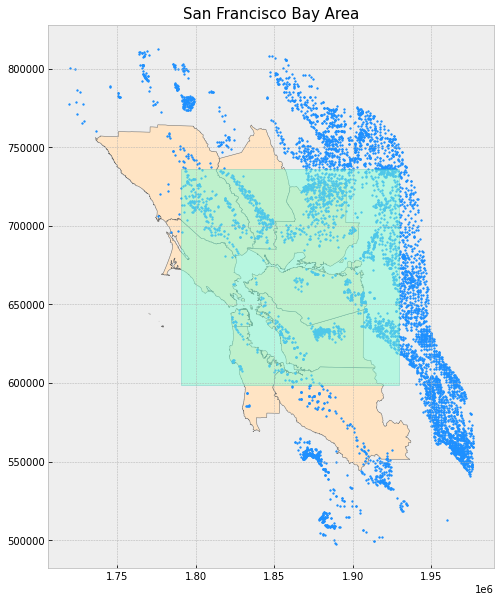

In [172]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
wells.plot(ax = ax, color = 'dodgerblue', markersize = 3)
poly.plot(ax = ax, color = 'aquamarine', edgecolor = 'lightseagreen', alpha = 0.5)

ax.set_title('San Francisco Bay Area', fontdict = {'fontsize': '15'})

plt.show()

## Clip Spatial Polygons

Clip extracts and keeps only the geometries of a vector feature that are within extent of another vector feature (think of it like a cookie-cutter or mask). We can use `clip()` in geopandas, with the first parameter being the vector that will be clipped and the second parameter being the vector that will define the extent of the clip. *All attributes for the resulting clipped vector will be kept*.

We will first clip the Bay Area counties polygon to our created rectangle polygon.

coname                                           geometry
8         Sonoma County  POLYGON ((1813621.641 736108.000, 1813605.098 ...
4  San Francisco County  MULTIPOLYGON (((1834364.295 641524.540, 183435...
2          Marin County  MULTIPOLYGON (((1822277.787 655539.623, 182231...
3           Napa County  POLYGON ((1860171.549 724651.231, 1860170.736 ...
5      San Mateo County  MULTIPOLYGON (((1850042.437 615031.357, 185003...
7         Solano County  MULTIPOLYGON (((1875491.908 673077.900, 187549...
1   Contra Costa County  MULTIPOLYGON (((1836501.066 656512.837, 183649...
0        Alameda County  MULTIPOLYGON (((1860234.837 612219.122, 186007...
6    Santa Clara County  MULTIPOLYGON (((1858733.082 607586.450, 185874...

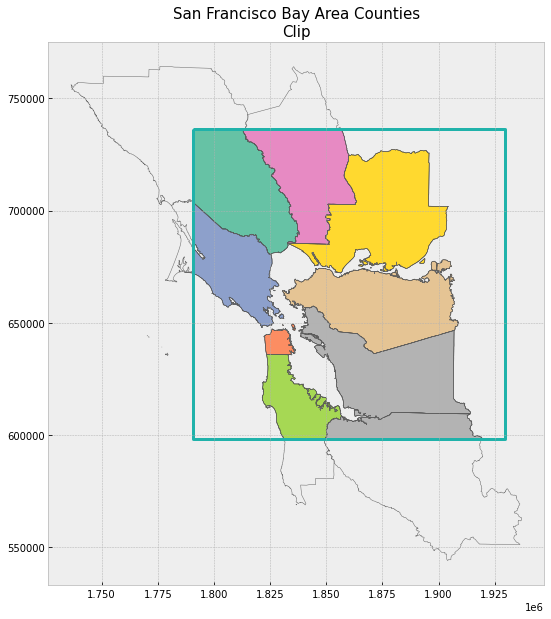

In [173]:
# Clip data
clip_counties = gpd.clip(counties, poly)

# Display attribute table
display(clip_counties)

# Plot clip
plot_df(result_name = 'San Francisco Bay Area Counties\nClip', result_df = clip_counties, result_geom_type = 'polygon', area = poly)

Next, we'll clip the wells point data to our created rectangle polygon.

WELL_NAME     WELL_USE                               WELL_TYPE  \
994         SSWD 47        Other                             Single Well   
95          SSWD 69        Other                             Single Well   
2156          MW12D  Observation  Part of a nested/multi-completion well   
2155          MW12E  Observation  Part of a nested/multi-completion well   
2154          MW12C  Observation  Part of a nested/multi-completion well   
...             ...          ...                                     ...   
1606          MW-4A  Observation  Part of a nested/multi-completion well   
1616          MW-4C  Observation  Part of a nested/multi-completion well   
5071           None      Unknown                                 Unknown   
5222  09N09W28N001M   Irrigation                             Single Well   
1727        AVAA-12   Irrigation                             Single Well   

      WELL_DEPTH                        geometry  
994          350  POINT (1925783.386 732796.136)  
95           425  POINT (1921709.808 732832.127)  
2156         845  POINT (1921726.124 732861.723)  
2155        1005  POINT (1921726.124 732861.723)  
2154         615  POINT (1921726.124 732861.723)  
...          ...                             ...  
1606         505  POINT (1918390.228 635230.531)  
1616         820  POINT (1918390.228 635230.531)  
5071           0  POINT (1907552.324 635281.368)  
5222          53  POINT (1793563.601 734808.898)  
1727           0  POINT (1804172.745 735379.942)  

[2013 rows x 5 columns]

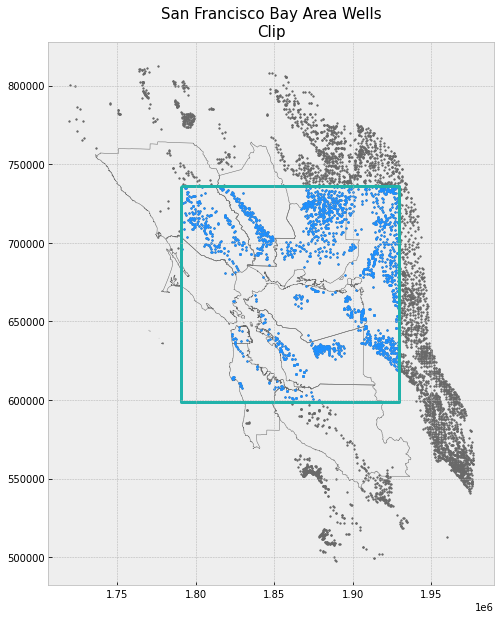

In [174]:
# Clip data
clip_wells = gpd.clip(wells, poly)

# Display attribute table
display(clip_wells)

# Plot clip
plot_df(result_name = 'San Francisco Bay Area Wells\nClip', result_df = clip_wells, result_geom_type = 'point', area = poly)

## Select Location by Attributes

Selecting by attribute selects only the features in a dataset whose attribute values match the specified criteria. geopandas uses the indexing and selection methods in pandas, so data in a GeoDataFrame can be selected and queried in the same way a pandas dataframe can.

We will use different criteria to subset the wells dataset. This can use a variety of operators, including comparison and logical operators.

In [175]:
# Select wells that are public supply
wells_public = wells[(wells['WELL_USE'] == 'Public Supply')]

# Display rows
display_table(table_name = 'San Francisco Bay Area Wells - Public Supply', attribute_table = wells_public)

Attribute Table: San Francisco Bay Area Wells - Public Supply

Table shape (rows, columns): (33, 5)

First two rows:


WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
0  2400064-001  Public Supply  Single Well           0   
1  2400099-001  Public Supply  Single Well           0   

                         geometry  
0  POINT (1968290.923 592019.918)  
1  POINT (1969113.543 595876.691)


Last two rows:


WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
3368   Aptos Creek PW  Public Supply  Single Well         713   
3369  Country Club PW  Public Supply  Single Well         495   

                            geometry  
3368  POINT (1875127.938 553764.966)  
3369  POINT (1877219.818 552137.819)

In [176]:
# Select wells that are public supply and have a depth greater than 50 ft
wells_public_deep = wells[(wells["WELL_USE"] == "Public Supply") & (wells["WELL_DEPTH"] > 50)]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft", attribute_table = wells_public_deep)

Attribute Table: San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft

Table shape (rows, columns): (24, 5)

First two rows:


WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
919        Granite Way PW  Public Supply  Single Well         670   
1082  Aptos Jr. High 2 PW  Public Supply  Single Well         590   

                            geometry  
919   POINT (1875403.340 554078.279)  
1082  POINT (1876872.389 553821.138)


Last two rows:


WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
3368   Aptos Creek PW  Public Supply  Single Well         713   
3369  Country Club PW  Public Supply  Single Well         495   

                            geometry  
3368  POINT (1875127.938 553764.966)  
3369  POINT (1877219.818 552137.819)

In [177]:
# Select wells that are public supply and have a depth greater than 50 ft OR are residential
wells_public_deep_residential = wells[((wells["WELL_USE"] == "Public Supply") & (wells["WELL_DEPTH"] > 50)) | (wells["WELL_USE"] == "Residential")]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft or Residential", attribute_table = wells_public_deep_residential)

Attribute Table: San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft or Residential

Table shape (rows, columns): (725, 5)

First two rows:


WELL_NAME     WELL_USE WELL_TYPE  WELL_DEPTH  \
137      None  Residential   Unknown          78   
138      None  Residential   Unknown          80   

                           geometry  
137  POINT (1886296.744 730378.969)  
138  POINT (1877320.295 730464.652)


Last two rows:


WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
6032   GV FARM  Residential  Single Well          67   
6033      None  Residential      Unknown          76   

                            geometry  
6032  POINT (1855297.377 693189.634)  
6033  POINT (1841755.238 707939.225)

## Select by Location

Selecting by location selects features based on its relative spatial relationship with another dataset. In other words, features are selected based on their location relative to the location of another dataset.

For example:
- To know how many wells there are in Santa Clara County, we could select all the wells that fall within Santa Clara County boundaries (which we do in one of the examples below)
- To know what rivers flow through Santa Clara County, we could select all the river polylines that intersect with Santa Clara County boundaries

There are multiple spatial relationships available in geopandas:

| Spatial Relationship | Function(s) | Description |
| --- | --- | --- |
| contains | `contains()` | Geometry encompasses the other geometry's boundary and interior without any boundaries touching |
| covers | `covers()` | All of the geometry's points are to the exterior of the other geometry's points |
| covered by | `covered_by()` | All of the geometry's points are to the interior of the other geometry's points |
| crosses | `crosses()` | Geometry's interior intersects that of the other geometry, provided that the geometry does not contain the other and the dimension of the intersection is less than the dimension of either geometry |
| disjoint | `disjoint()` | geometry's boundary and interior do not intersect the boundary and interior of the other geometry |
| equal geometry | `geom_equals()`, `geom_almost_equals()`, `geom_equals_exact()` | Geometry's boundary, interior, and exterior matches (within a range) those of the other |
| intersects | `intersects()` | Geometry's boundary or interior touches or crosses any part of the other geometry |
| overlaps | `overlaps()` | Geometry shares at least one point, but not all points, with the other geometry, provided that the geometries and the intersections of their interiors all have the same dimensions |
| touches | `touches()` | Geometry shares at least one point with the other geometry, provided that no part of the geometry's interior intersects with the other geometry |
| within | `within()` | Geometry is encoldsed in the other geometry (geometry's boundary and interior intersects with the other geometry's interior only) |

The functions for these spatial relationships will generally output a pandas series with Boolean values (`True` or `False`) whose indexing corresponds with the input dataset (from where we want to subset the data). We can use these Boolean values to subset the dataset (where only the rows that have a `True` output will be retained).

 ### Method 1 - Shapely vector

These functions can be used to select features that have the specified spatial relationship with a single Shapely vector.

Attribute Table: San Francisco Bay Area Wells within a User-defined Rectangle

Table shape (rows, columns): (2013, 5)

First two rows:


WELL_NAME WELL_USE    WELL_TYPE  WELL_DEPTH  \
2   Flag City Well 3  Unknown  Single Well           0   
14  Flag City Well 1  Unknown  Single Well         170   

                          geometry  
2   POINT (1922067.711 679380.918)  
14  POINT (1922680.537 679641.516)


Last two rows:


WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
6032   GV FARM  Residential  Single Well          67   
6033      None  Residential      Unknown          76   

                            geometry  
6032  POINT (1855297.377 693189.634)  
6033  POINT (1841755.238 707939.225)

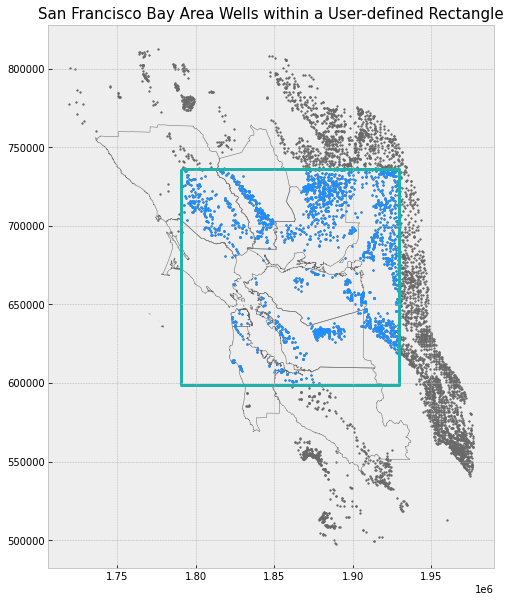

In [178]:
# Select wells that fall within Shapely rectangle
wells_within_rect_shapely = wells[wells.within(poly_shapely)]

# Display first two and last two rows of attribute table
display_table(table_name = 'San Francisco Bay Area Wells within a User-defined Rectangle', attribute_table = wells_within_rect_shapely)

# Plot selection
plot_df(result_name = 'San Francisco Bay Area Wells within a User-defined Rectangle', result_df = wells_within_rect_shapely, result_geom_type = 'point', area = poly)

### Method 2 - GeoDataFrame

If we’re trying to select features that have a specified spatial relationship with another geopandas object, it gets a little tricky because the geopandas spatial relationship functions verify the spatial relationship either **row by row** or **index by index**. In other words, the first row in the first dataset will be compared with the corresponding row or index in the second dataset, the second row in the first dataset will be compared with the corresponding row or index in the second dataset, and so on.

As a result, the number of rows need to correspond or the indices numbers need to match between the two datasets –- or else we’ll get a warning and the output will be empty.

Because each record in a GeoDataFrame has a geometry column that stores that record’s geometry as a shapely object, we can call this object if we want to check a bunch of features against one extent (with one geometry).

Attribute Table: San Francisco Bay Area Wells within Santa Clara County

Table shape (rows, columns): (136, 5)

First two rows:


WELL_NAME     WELL_USE  \
980   CalFire Pacheco No 2  Residential   
1020          05S02W35R002  Observation   

                                   WELL_TYPE  WELL_DEPTH  \
980                              Single Well           0   
1020  Part of a nested/multi-completion well          80   

                            geometry  
980   POINT (1924674.853 557296.117)  
1020  POINT (1863211.218 606236.916)


Last two rows:


WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
5962  07S01W25L001  Observation  Single Well         404   
6036  06S02W34B006  Observation  Single Well         152   

                            geometry  
5962  POINT (1873814.137 589052.339)  
6036  POINT (1861394.207 597916.983)

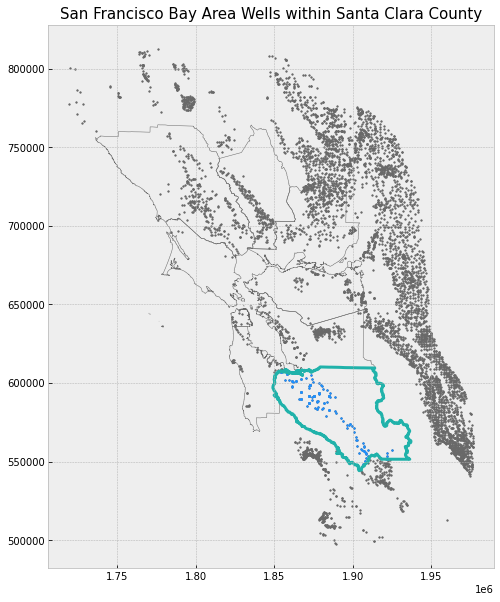

In [179]:
# Select the Santa Clara County boundary
sc_county = counties[counties['coname'] == 'Santa Clara County']

# Subset the GeoDataFrame by checking which wells are within Santa Clara County's Shapely object
wells_within_sc_shapely = wells[wells.within(sc_county.geometry.values[0])]

# Display
display_table(table_name = 'San Francisco Bay Area Wells within Santa Clara County', attribute_table = wells_within_sc_shapely)

# Plot selection
plot_df(result_name = 'San Francisco Bay Area Wells within Santa Clara County', result_df = wells_within_sc_shapely, result_geom_type = 'point', area = sc_county)

If we are interested in wells that fall within two or more counties (i.e., we have multiple records that will be used for selection), we can enclose the above code in a `for` loop.

# Spatial Overlays and Joins

Combining two or more datasets together is a fundamental aspect of GIS. Using geopandas, we can create new geometries from existing datasets by overlaying them on top of each other, identifying where they do and do not overlap, and deciding what parts we want to extract from these overlays. For each of these new shapes, the attribute data from the existing constituent datasets are also combined together.

In this chapter, we will focus on vector overlays, which involve combining vector data. We’ll explore five types of vector overlays and merging: union, intersection, difference (erase), identity, and spatial join.

## Setup

To illustrate these geoprocessing tools, we will utilize shapefiles of San Francisco Bay Area county boundaries, Bay Area watershed boundaries, and wells within the Bay Area and the surrounding 50 km. We will load in the data and reproject the data.

In [180]:
# Load more data
watersheds = gpd.read_file(os.getcwd() + '/data/static/sf_bay_watersheds/sf_bay_watersheds.shp')
watersheds = watersheds.to_crs(proj)

def plot_overlay(overlay_type, overlay_result):
    '''Plot the overlay result on a map and add the outlines of the original shapefiles on top.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot overlay data
    overlay_result.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

    # Plot outlines of original shapefiles
    counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
    watersheds.plot(ax = ax, color = 'none', edgecolor = 'dodgerblue')

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title('San Francisco Bay Area County and Watershed Boundaries\n{}'.format(overlay_type), fontdict = {'fontsize': '15', 'fontweight' : '3'})


def plot_merge(merge_type, merge_result, merge_vector):
    '''Plot the merge result on a map.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot data depending on vector type
    # For points
    if merge_vector == "point":

        # Plot data
        counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
        merge_result.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)

    # For polygons
    else:

        # Plot data
        merge_result.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title('San Francisco Bay Area County Boundaries and Well Locations\n{}'.format(merge_type), fontdict = {'fontsize': '15', 'fontweight' : '3'})

## Overlays

For the first four, we can use the overlay function in geopandas. We simply change the argument for the how parameter to the overlay of our choosing.

We will use the county boundaries and watershed boundaries shapefiles in these examples. The overlays will allow us to see what areas are only in a county, only in a watershed, or in both.

Let’s briefly examine the attribute table of our shapefiles and plot the data so that we know what we’re working with.

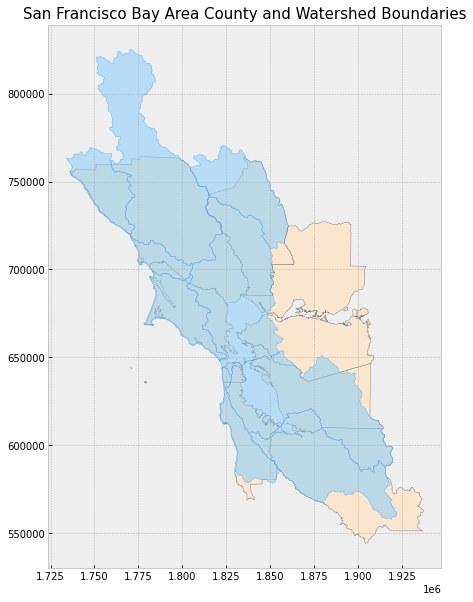

In [181]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray', alpha = 0.75)
watersheds.plot(ax = ax, color = 'lightskyblue', edgecolor = 'dodgerblue', alpha = 0.55)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('San Francisco Bay Area County and Watershed Boundaries', fontdict = {'fontsize': '15', 'fontweight' : '3'})
plt.show()

### Union

With `how = 'union'`, all data (all geometries regardless of overlap) is kept.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/vector_union.jpg'>
</p>

Looking at the attribute table, we see that the attributes from both individual datasets have been combined. The areas that are unique to one dataset (no overlap) have `NaN` as values in the fields that originated from the other dataset.

Attribute Table: Union

Table shape (rows, columns): (46, 3)

First two rows:


coname         CUNAME  \
0       Alameda County  SAN_PABLO_BAY   
1  Contra Costa County  SAN_PABLO_BAY   

                                            geometry  
0  POLYGON ((1844308.600 657338.949, 1844333.772 ...  
1  MULTIPOLYGON (((1850634.982 650633.799, 185062...


Last two rows:


coname                       CUNAME  \
44    NaN  SAN_FRANCISCO_COASTAL_SOUTH   
45    NaN                       COYOTE   

                                             geometry  
44  MULTIPOLYGON (((1853786.587 588015.011, 185377...  
45  MULTIPOLYGON (((1915223.216 583816.737, 191541...

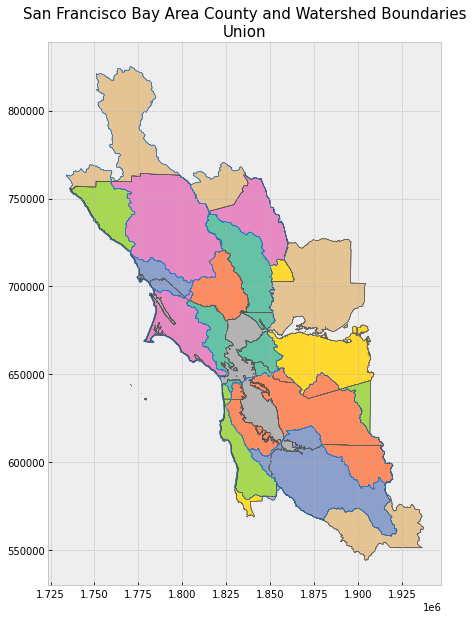

In [182]:
# Get union
union_result = gpd.overlay(counties, watersheds, how = 'union')

# Print head and tail of attribute table
display_table(table_name = "Union", attribute_table = union_result)

# Plot overlay
plot_overlay(overlay_type = "Union", overlay_result = union_result)

### Intersection

With `how = 'intersection'`, only the areas where all datsets contain data (have geometries) are combined together.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/vector_intersection.jpg'>
</p>

Because there are no areas unique to one dataset, notice how the attribute table of the combined dataset does not have any `NaN` values. When mapping the intersection overlay, we can see that any areas that did not have any overlay were discarded (areas with an outline but no fill). Areas covered by the county and watershed boundaries datasets are kept (shown in color). 

Attribute Table: Intersection

Table shape (rows, columns): (28, 3)

First two rows:


coname         CUNAME  \
0       Alameda County  SAN_PABLO_BAY   
1  Contra Costa County  SAN_PABLO_BAY   

                                            geometry  
0  POLYGON ((1844308.600 657338.949, 1844333.772 ...  
1  MULTIPOLYGON (((1850634.982 650633.799, 185062...


Last two rows:


coname                       CUNAME  \
26  Santa Clara County  SAN_FRANCISCO_COASTAL_SOUTH   
27       Sonoma County               GUALALA-SALMON   

                                             geometry  
26  MULTIPOLYGON (((1855641.060 585520.902, 185560...  
27  MULTIPOLYGON (((1770306.496 719948.583, 177028...

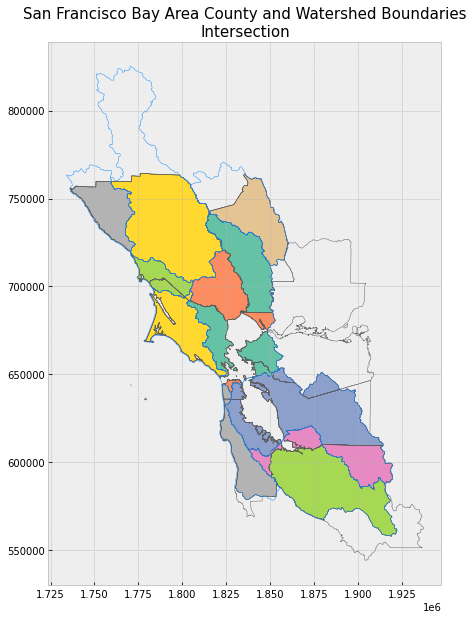

In [183]:
# Get intersection
intersection_result = gpd.overlay(counties, watersheds, how = 'intersection')

# Print head and tail of attribute table
display_table(table_name = "Intersection", attribute_table = intersection_result)

# Plot overlay
plot_overlay(overlay_type = "Intersection", overlay_result = intersection_result)

### Identity

With `how = 'identity'`, data from both layers are combined, but only the geometries that are unique to the first dataset or are covered by both datasets are kept. Any geometries unique to the second dataset (no overlapping with the first dataset) are discarded.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/vector_identity.jpg'>
</p>

Looking at the attribute table, the fields from the individual datasets have been combined. For those geometries unique to the first dataset, the fields that came from the second dataset have `NaN` as values.

Looking at the map, we see all combined geometries except for the areas that are unique to the second dataset (watershed boundaries dataset).

Attribute Table: Identity

Table shape (rows, columns): (37, 3)

First two rows:


coname         CUNAME  \
0       Alameda County  SAN_PABLO_BAY   
1  Contra Costa County  SAN_PABLO_BAY   

                                            geometry  
0  POLYGON ((1844308.600 657338.949, 1844333.772 ...  
1  MULTIPOLYGON (((1850634.982 650633.799, 185062...


Last two rows:


coname CUNAME                                           geometry
35  Solano County    NaN  MULTIPOLYGON (((1879629.756 727080.818, 187969...
36  Sonoma County    NaN  MULTIPOLYGON (((1804439.333 758178.073, 180446...

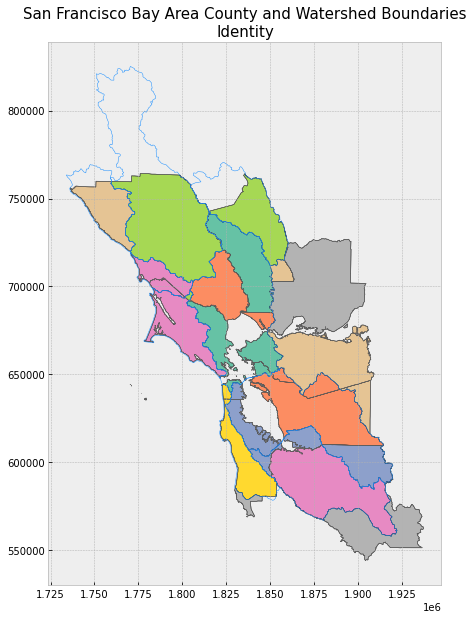

In [184]:
# Get identity
identity_result = gpd.overlay(counties, watersheds, how = 'identity')

# Print head and tail of attribute table
display_table(table_name = "Identity", attribute_table = identity_result)

# Plot overlay
plot_overlay(overlay_type = "Identity", overlay_result = identity_result)

### Difference (Erase)

With `how = 'difference'`, the areas covered by the second dataset is used to “cut out” or erase those corresponding areas in the first dataset. In other words, only the areas in the first dataset that do not overlap with the second dataset are kept. 

<p align = 'center'>
    <img src = 'https://pygis.io/_images/vector_erase.jpg'>
</p>

Looking at the attribute table, the fields from the second dataset do not appear in the combined dataset. The second dataset was “combined” with the first dataset by discarding some data (altering the geometry) from the first dataset.

Looking at the map, we only see areas of the first dataset (county dataset) that are not covered by the second dataset (watershed boundaries dataset).

Attribute Table: Difference

Table shape (rows, columns): (9, 2)

First two rows:


coname                                           geometry
0       Alameda County  MULTIPOLYGON (((1913747.025 610819.209, 191379...
1  Contra Costa County  MULTIPOLYGON (((1866870.506 674116.607, 186699...


Last two rows:


coname                                           geometry
7  Solano County  MULTIPOLYGON (((1879629.756 727080.818, 187969...
8  Sonoma County  MULTIPOLYGON (((1804439.333 758178.073, 180446...

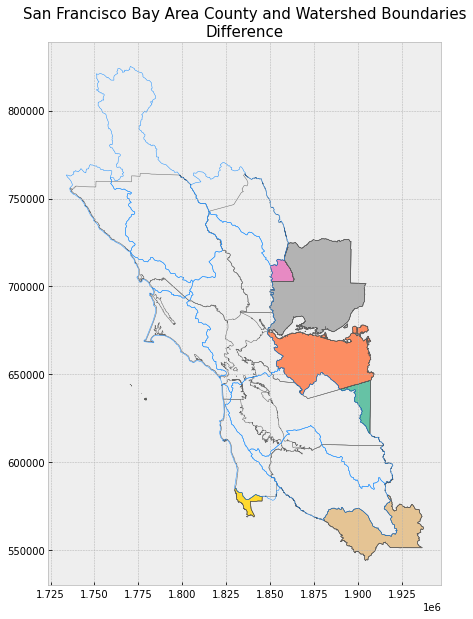

In [185]:
# Get difference
difference_result = gpd.overlay(counties, watersheds, how = 'difference')

# Print head and tail of attribute table
display_table(table_name = "Difference", attribute_table = difference_result)

# Plot overlay
plot_overlay(overlay_type = "Difference", overlay_result = difference_result)

## Merge (Spatial Join)

With spatial join, attributes from one dataset are appended to those in another dataset based on a specified relative spatial relationship.

In geopandas, we use the `sjoin()` function. In addition to passing the datasets as arguments, and we also pass arguments for two parameters `op` and `how`. The `op` parameter **specifies the spatial relationship needed in order for the attributes of one feature to be joined to another**.

Depending on the argument specified in the `op` parameter, a geometry that falls directly on the boundary of another geometry may be counted, may be counted twice, or may not be counted at all. For example, if a point falls on a boundary between two geometries, `op = "intersects"` will count that point twice and allocate (join) it to both geometries that share the boundary, whereas `op = "within"` will not count or allocate the point at all.

Just like regular table joins, there are multiple types of spatial joins, which determine which features from both datasets are kept in the output dataset. This is specified using the `how` parameter.

| Join Type | Description |
| --- | --- |
| `left` | All features from the first or left dataset are kept, regardless if the feature met the specified spatial relationship criteria for a join / regardless if there is a match |
| `right` | All features from the second or right dataset are kept, regardless if the feature met the specified spatial relationship for a join |
| `inner` | Only features from both datasets that met the spatial relationship and were joined are kept; the geometries from the first or left dataset are used for the join |

We’ll illustrate this geoprocessing using the county boundaries shapefile and the well locations shapefile. Let’s quickly examine the wells attribute table and plot both datasets.

Attribute Table: San Francisco Bay Area and Surrounding Area Wells

Table shape (rows, columns): (6037, 5)

First two rows:


WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
0  2400064-001  Public Supply  Single Well           0   
1  2400099-001  Public Supply  Single Well           0   

                         geometry  
0  POINT (1968290.923 592019.918)  
1  POINT (1969113.543 595876.691)


Last two rows:


WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
6035          None      Unknown      Unknown           0   
6036  06S02W34B006  Observation  Single Well         152   

                            geometry  
6035  POINT (1960933.648 610295.428)  
6036  POINT (1861394.207 597916.983)

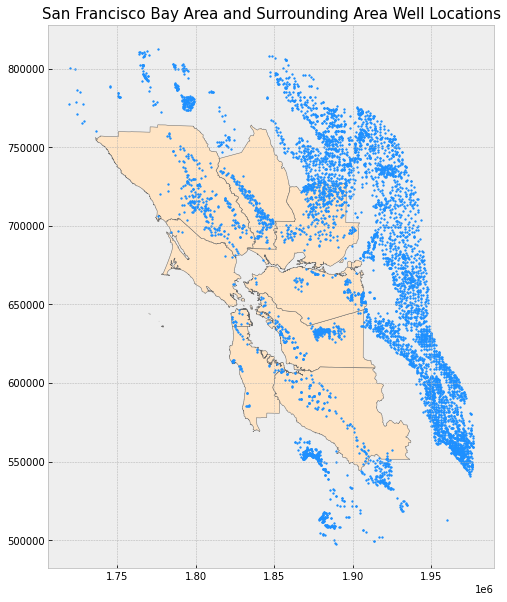

In [186]:
# Prick head and tail of attribute table
display_table(table_name = 'San Francisco Bay Area and Surrounding Area Wells', attribute_table = wells)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgrey')
wells.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)

# Set title
ax.set_title('San Francisco Bay Area and Surrounding Area Well Locations', fontdict = {'fontsize': '15'})

plt.show()

### Left Join

We’ll first demonstrate a left join. Notice that all features from the left dataset (wells dataset) are kept. The features that did not meet the spatial relationship criteria for a join have `NaN` as values for the fields that originated from the right dataset (county boundaries dataset).

Attribute Table: Left Join

Table shape (rows, columns): (6037, 7)

First two rows:


c:\Users\gilramolete\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
0  2400064-001  Public Supply  Single Well           0   
1  2400099-001  Public Supply  Single Well           0   

                         geometry  index_right coname  
0  POINT (1968290.923 592019.918)          NaN    NaN  
1  POINT (1969113.543 595876.691)          NaN    NaN


Last two rows:


WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
6035          None      Unknown      Unknown           0   
6036  06S02W34B006  Observation  Single Well         152   

                            geometry  index_right              coname  
6035  POINT (1960933.648 610295.428)          NaN                 NaN  
6036  POINT (1861394.207 597916.983)          6.0  Santa Clara County

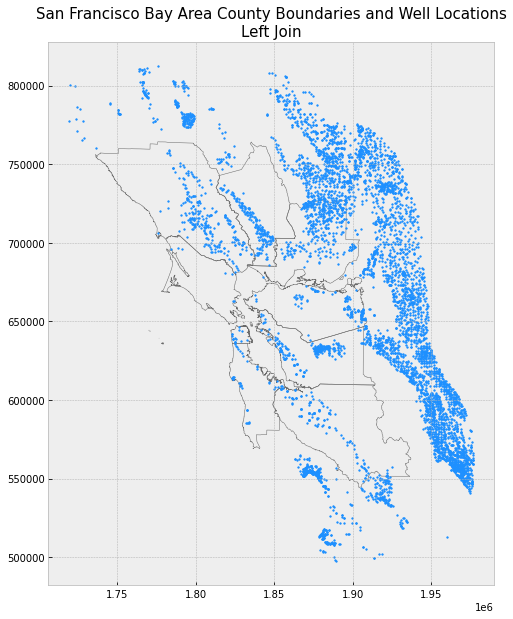

In [187]:
# Get inner join
left_join_result = gpd.sjoin(wells, counties, how = 'left', op = 'within')

display_table(table_name = 'Left Join', attribute_table = left_join_result)
plot_merge(merge_type = 'Left Join', merge_result = left_join_result, merge_vector = 'point')

### Right Join

For a right join, all features from the right dataset (county boundaries dataset) are kept but are repeated multiple times. This is because a “new” county feature is created for every well point that falls within a county’s boundary. As a result, because wells must fall within the county boundaries for a join to occur on the county boundaries feature, there are no resulting features with `NaN` as values in the attribute table.

The results here are a bit useless, since it’s just each county boundary multiplied by the number of wells in that county, but we kept this example for comprehensiveness.

Attribute Table: Right Join

Table shape (rows, columns): (1337, 7)

First two rows:


c:\Users\gilramolete\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


index_left    WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
0         787  3S/1E  9M 4   Industrial  Single Well         498   
0         755  3S/1E  8H13  Observation  Single Well         800   

           coname                                           geometry  
0  Alameda County  MULTIPOLYGON (((1860234.837 612219.122, 186007...  
0  Alameda County  MULTIPOLYGON (((1860234.837 612219.122, 186007...


Last two rows:


index_left      WELL_NAME     WELL_USE    WELL_TYPE  WELL_DEPTH  \
8        1697        AVCA-01  Residential  Single Well         100   
8        3508  11N10W08P001M  Residential  Single Well          30   

          coname                                           geometry  
8  Sonoma County  MULTIPOLYGON (((1746855.532 743026.706, 174685...  
8  Sonoma County  MULTIPOLYGON (((1746855.532 743026.706, 174685...

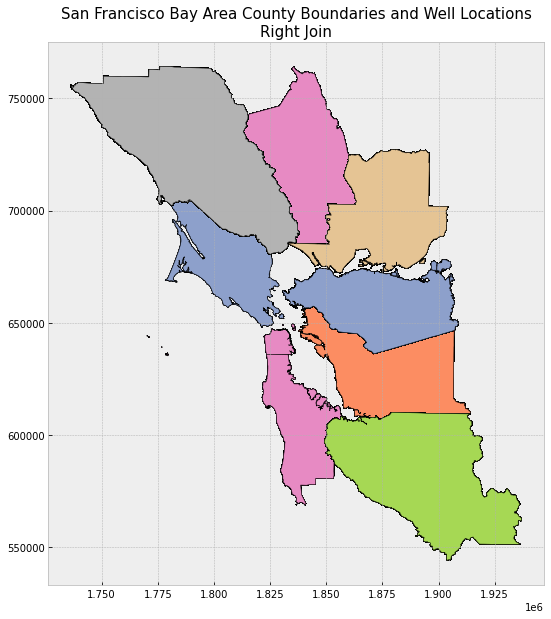

In [188]:
# Get right join
right_join_result = gpd.sjoin(wells, counties, how = 'right', op = 'within')

display_table(table_name = "Right Join", attribute_table = right_join_result)
plot_merge(merge_type = "Right Join", merge_result = right_join_result, merge_vector = "polygon")

### Inner Join

Finally, with an inner join, only the well locations that fall within the county boundaries are kept. These well locations have the county boundaries dataset appended to them. Because it’s an inner join, there are no resulting features with `NaN` as values in the attribute table.

Attribute Table: Inner Join

Table shape (rows, columns): (1337, 7)

First two rows:


c:\Users\gilramolete\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


WELL_NAME       WELL_USE WELL_TYPE  WELL_DEPTH  \
128      None  Stockwatering   Unknown          40   
129      None     Irrigation   Unknown         240   

                           geometry  index_right         coname  
128  POINT (1882982.865 701605.988)            7  Solano County  
129  POINT (1884096.112 699303.331)            7  Solano County


Last two rows:


WELL_NAME     WELL_USE                               WELL_TYPE  \
1759  T2S/R5W-06M01  Residential                             Single Well   
2316  Kirkham MW130  Observation  Part of a nested/multi-completion well   

      WELL_DEPTH                        geometry  index_right  \
1759         275  POINT (1827410.559 644648.215)            4   
2316         130  POINT (1823285.838 641661.323)            4   

                    coname  
1759  San Francisco County  
2316  San Francisco County

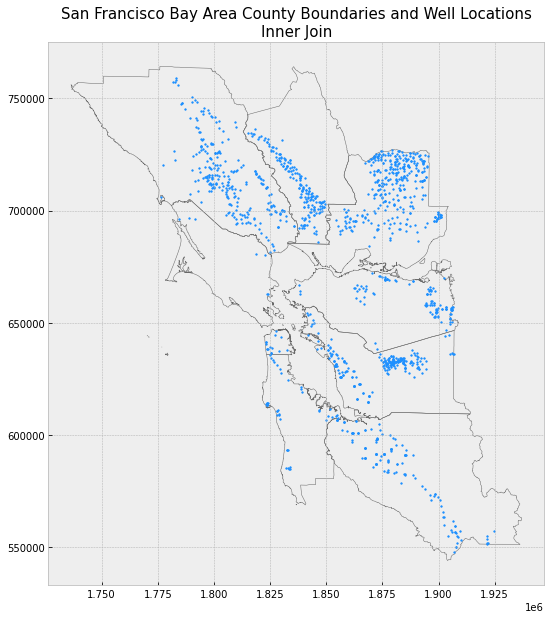

In [189]:
# Get inner join
inner_join_result = gpd.sjoin(wells, counties, how = 'inner', op = 'within')

display_table(table_name = 'Inner Join', attribute_table = inner_join_result)
plot_merge(merge_type = 'Inner Join', merge_result = inner_join_result, merge_vector = 'point')

# Spatial Joins

To spatially join one dataset to another, attributes from the first dataset (join feature) are appended to the attributes in the second dataset (target feature) based on the relative spatial relationship between the two datasets’ geometries.

Note: Unlike table joins by attributes, we’re not really concerned with the tables having a primary key (a column, or columns, that uniquely identifies each record in a table) to conduct a join. Instead, the relative spatial location between the features in two datasets will determine what gets joined.

## Spatial Join Relationships

There are multiple spatial join relationships that we can specify. Only the features that meet the specified spatial relationship criteria will be joined together. The spatial arrangement necessary to satisfy a specified spatial relationship **depends on the vector types (i.e., point, line, polygon)** of the join feature and the **target feature**. Note that some spatial relationships are not possible for certain combinations of vector types.

Below is a description of the spatial relationships available in the geopandas module (this list is not necessarily exhaustive). We also provide diagrams visualizing the spatial arrangement needed for various combinations of vector types to satisfy the spatial relationship criteria and allow for a join.

### Contains

One feature contains another if the geometry’s points are **not to the exterior of the other’s geometry** and the **geometry’s interior contains at least one point of the other geometry’s interior**.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/overlay_contains.jpg'>
</p>

### Crosses

The geometry’s **interior crosses that of the other geometry**, provided that **the geometry does not contain the other** and the **dimension of the intersection is less than the dimension of either geometry**.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/overlay_crosses.jpg'>
</p>

### Intersects

A feature intersects another if the **geometry's boundary or interior has any part in common** with the other geometry.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/overlay_intersects.jpg'>
</p>

### Overlaps

A feature overlaps another if the **geometry shares at least one point, but not all points, with the other geometry**, provided that the geometries and the intersection of their interiors all **have the same dimensions**.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/overlay_overlaps.jpg'>
</p>

### Touches

A feature touches another if **the geometry shares at least one point with the other geometry**, provided that **no part of the geometry’s interior intersects with the other geometry**.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/overlay_overlaps.jpg'>
</p>

### Within

A feature is within another if **the geometry is enclosed in the other geometry** (geometry’s boundary and interior intersects with the other geometry’s interior only).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/overlay_within.jpg'>
</p>

## Spatial Join Types

There are four types of spatial joins: **outer join, inner join, left join**, and **right join**. These spatial join types determine which features from both datasets are kept in the resulting output dataset.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/join_types.jpg'>
</p>

Only the inner, left, and right join types are available in the geopandas module and are identical to those in pandas.

- **Outer Join**
    - **All features from both datasets are kept**, regardless if the features meet the specified spatial relationship criteria for a join
    - As all attribute fields are combined, rows that do not have a match may have null values in the fields that originated from the other dataset
- **Inner Join**
    - Only features from both datasets **that meet the spatial relationship for the joined are kept**
    - The geometries from the first or left dataset are used for the join
- **Left Join**
    - All features from the **first or left dataset are kept**, regardless if the features meet the specified spatial relationship criteria for a join
    - As all attribute fields are combined, rows that do not have a match with the right dataset may have **null values** in the fields that originated from the right dataset
- **Right Join**
    - All features from the **second or right dataset are kept**, regardless if the features meet the specified spatial relationship criteria for a join
    - As all attribute fields are combined, rows that do not have a match with the left dataset may have **null values** in the fields that originated from the left dataset

## Table Relationships

Table relationships, or cardinality, **specify the direction of the join** and **the relationship between the two datasets**. There are four types of table relationships:
- One-to-one
- One-to-many
- Many-to-one, and
- Many-to-many. 

While these relationships are not specified as a parameter in the geopandas module when conducting a spatial join, it is important to have a general idea of the table relationship between the two datasets. Generally, a many-to-one join and a many-to-many join should be avoided because it can create ambiguity and unpredictability when analyzing and manipulating the resulting attribute table.

1. **One-to-one relationship**
Each feature in one geometry is **linked to one (and only one) feature in the second geometry** (and vice versa). Each feature in both datasets will appear only once at most. 

<p align = 'center'>
    <img src = 'https://pygis.io/_images/relationship_one_to_one.jpg'>
</p>

2. **One-to-many relationships or many-to-one relationships**
Each feature in one geometry is **linked to one or more features in the second geometry**. The output geometry may see **the “one” feature duplicated across multiple rows** to accommodate its multiple linkages in the other dataset (the “many”). A one-to-many or many-to-one relationship can be dependent on the spatial join type (for example, if a left join results in a one-to-many relationship, then a right join will result in a many-to-one relationship).

Warning: these two table relationships — while similar — are not the same! In a one-to-many relationship, the “many” geometry is the dataset that is being joined to. Alternatively, in a many-to-one relationship, the “one” geometry is the dataset being joined to. Thus, the many-to-one relationship can result in duplicate “one” geometries and create uncertainty, which is why a many-to-one join should be avoided.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/relationship_one_to_many.jpg'>
</p>

3. **Many-to-many relationships**
One or more features in one geometry are **linked** to one or more features in the second geometry. The output geometry may have multiple rows of each target and join feature to accommodate the multiple linkages, which can create ambiguity—hence why a many-to-many join should be avoided.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/relationship_many_to_many.jpg'>
</p>

To ensure you’re doing a one-to-one or one-to-many join, it may be helpful to envision your spatial join before performing a spatial join. Think about what geometries you will be joining to (the target feature) and what geometry or geometries from the join feature might be joined to one geometry in the target feature.

# Point Density Measures - Counts & Kernel Density

Summary operations are useful for aggregating data, whether it be for analyzing overall trends or visualizing concentrations of data. Summarizing allows for effective analysis and communication of the data as compared to simply looking at or displaying points, lines, and polygons on a map.

This chapter will explore two summary operations that highlight concentrations of data: count points in a rectangular or hexagonal grid or by polygon and kernel density.

In [190]:
wells['Well_ID'] = np.arange(wells.shape[0])
wells

WELL_NAME       WELL_USE    WELL_TYPE  WELL_DEPTH  \
0          2400064-001  Public Supply  Single Well           0   
1          2400099-001  Public Supply  Single Well           0   
2     Flag City Well 3        Unknown  Single Well           0   
3          2400077-001  Public Supply  Single Well           0   
4          2400215-011  Public Supply  Single Well           0   
...                ...            ...          ...         ...   
6032           GV FARM    Residential  Single Well          67   
6033              None    Residential      Unknown          76   
6034              None        Unknown      Unknown           0   
6035              None        Unknown      Unknown           0   
6036      06S02W34B006    Observation  Single Well         152   

                            geometry  Well_ID  
0     POINT (1968290.923 592019.918)        0  
1     POINT (1969113.543 595876.691)        1  
2     POINT (1922067.711 679380.918)        2  
3     POINT (1968870.873 592113.163)        3  
4     POINT (1970689.119 591528.334)        4  
...                              ...      ...  
6032  POINT (1855297.377 693189.634)     6032  
6033  POINT (1841755.238 707939.225)     6033  
6034  POINT (1961191.541 608718.281)     6034  
6035  POINT (1960933.648 610295.428)     6035  
6036  POINT (1861394.207 597916.983)     6036  

[6037 rows x 6 columns]

## Count Points in Rectangular or Hexagonal Grid or by Polygon

To summarize by grid, we create a new polygon layer consisting of a grid and overlay on another feature. We can summarize an aspect of that feature within each cell of the grid. The polygon layer commonly consists of a fishnet (rectangular cells), but using hexagons as a grid is becoming increasingly widespread.

Let’s define a function that will create a grid of either rectangles or hexagons of a specified side length.

In [191]:
def create_grid(feature, shape, side_length):
    """Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.

    Args:
        feature (_type_): _description_
        shape (_type_): _description_
        side_length (_type_): _description_
    """

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases the likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds

    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ['square', 'rectangle', 'box']:
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):
            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y, side_length, max_y + side_length, side_length):
                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length, side_length))
    
    # Otherwise, create grid of hexagons
    elif shape == 'hexagon':
        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values taht will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):
            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):
                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:
                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, add
            else:
                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem
            
            # Increase column number by 1
            column_number += 1
    
    # Else, raise error
    else:
        raise Exception("Specifiy a rectangle or hexagon as the grid shape.")
    
    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = proj)

    # Create a column that assigns each grid a number
    grid['Grid_ID'] = np.arange(len(grid))

    # Return grid
    return grid

We will illustrate this methodology by counting the number of well points within each cell of the grid. There are two different ways we can accomplish this methodology, both with advantages and disadvantages.

To begin, we will set some global parameters for both examples.

In [192]:
# Set side length for cells in grid
# This is dependent on projection chosen as length is in units specified in projection
side_length = 5000

# Set shape of grid
shape = 'hexagon'
# shape = 'rectangle'

### Method 1 - Group by

This method involves using spatial joins to allocate each point to the cell in which it resides. All the points within each cell are subsequently grouped together and counted.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/PointDensity_Groupby.png'>
</p>

First, we will create a grid over the Bay Area.

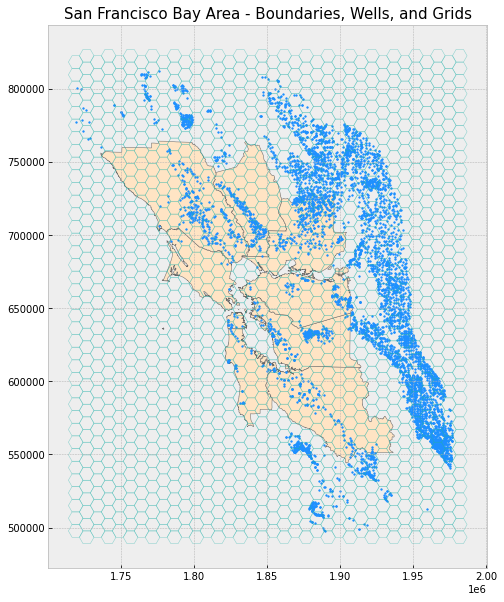

In [193]:
# Create grid
bay_area_grid = create_grid(feature = wells, shape = shape, side_length = side_length)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgrey')
wells.plot(ax = ax, color = 'dodgerblue', marker = 'o', markersize = 3)
bay_area_grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.5)

# Set title
ax.set_title('San Francisco Bay Area - Boundaries, Wells, and Grids', fontdict = {'fontsize': '15'})
plt.show()

Next, we will conduct a spatial join for each well point, essentially assigning it to a cell. We can add a field with a value of `1`, group all the wells in a cell, and aggregate (sum) all those `1` values to get the total number of wells in a cell.

In [194]:
# Perform spatial join, merging attribute table of wells point and that of the cell with which its intersects
    # ops = 'intersects' also counts those that fall on a cell boundary (between two cells)
    # ops = 'within' will not count those fall on a cell boundary
wells_cell = gpd.sjoin(wells, bay_area_grid, how = 'inner', op = 'intersects')

# Remove duplicate counts
    # With intersect, those that fall on a boundary will be allocated to all cells that share that boundary
wells_cell = wells_cell.drop_duplicates(subset = ['Well_ID']).reset_index(drop = True)

# Set field name to hold count value
count_field = 'Count'

# Add a field with constant value of 1
wells_cell[count_field] = 1

# Group GeoDataFrame by cell while aggregating the Count values
wells_cell = wells_cell.groupby('Grid_ID').agg({count_field: 'sum'})

# Merge the resulting grouped dataframe with the grid GeoDataFrame, using a left join to keep all cell polygons
bay_area_grid = bay_area_grid.merge(wells_cell, on = 'Grid_ID', how = 'left')

# Fill the NaN values (cells without any points) with 0
bay_area_grid[count_field] = bay_area_grid[count_field].fillna(0)

# Convert Count field to integer
bay_area_grid[count_field] = bay_area_grid[count_field].astype(int)

# Display grid attribute table
display(bay_area_grid)

c:\Users\gilramolete\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


geometry  Grid_ID  Count
0     POLYGON ((1724272.398 497763.821, 1721772.398 ...        0      0
1     POLYGON ((1724272.398 506424.075, 1721772.398 ...        1      0
2     POLYGON ((1724272.398 515084.329, 1721772.398 ...        2      0
3     POLYGON ((1724272.398 523744.583, 1721772.398 ...        3      0
4     POLYGON ((1724272.398 532404.837, 1721772.398 ...        4      0
...                                                 ...      ...    ...
1381  POLYGON ((1986772.398 787882.331, 1984272.398 ...     1381      0
1382  POLYGON ((1986772.398 796542.585, 1984272.398 ...     1382      0
1383  POLYGON ((1986772.398 805202.839, 1984272.398 ...     1383      0
1384  POLYGON ((1986772.398 813863.093, 1984272.398 ...     1384      0
1385  POLYGON ((1986772.398 822523.347, 1984272.398 ...     1385      0

[1386 rows x 3 columns]

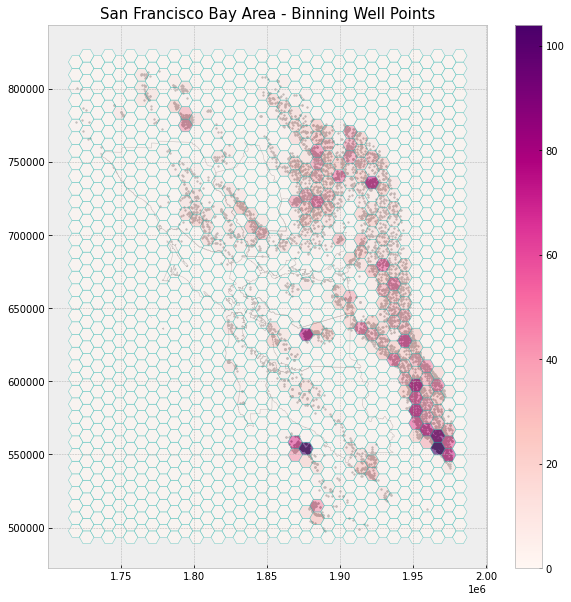

In [195]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

counties.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
wells.plot(ax = ax, marker = 'o', color = 'dimgrey', markersize = 3)
bay_area_grid.plot(ax = ax, column = 'Count', cmap = 'RdPu', edgecolor = 'lightseagreen', linewidth = 0.5, alpha = 0.60, legend = True)

ax.set_title('San Francisco Bay Area - Binning Well Points', fontdict = {'fontsize': '15'})
plt.show()

The advantage of this method is that it is pretty fast. To verify that all points have been counted once, we can check the aggregate of all the point sums for each cell.

In [196]:
print(f'Total number of well points counted: {sum(bay_area_grid["Count"])}\nNumber of well points in input data: {len(wells)}')

Total number of well points counted: 6037
Number of well points in input data: 6037


### Method 2 - Iterate through each feature

This second method is slightly more intuitive, but it can take a long time to run. We will use a subset of the input data–those that fall within Santa Clara County–to illustrate this example. We will first subset our data to Santa Clara County.

In [197]:
sc_county

coname                                           geometry
6  Santa Clara County  MULTIPOLYGON (((1858733.082 607586.450, 185874...

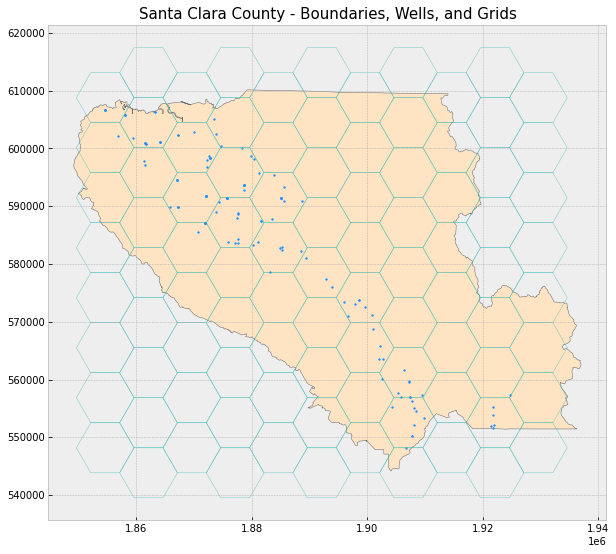

In [198]:
# Subset the GeoDataFrame by checking which wells are within Santa Clara County
sc_county_wells = wells[wells.within(sc_county['geometry'].values[0])]

# Create grids
sc_county_grid = create_grid(sc_county_wells, shape = shape, side_length = side_length)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

sc_county.plot(ax = ax, color = 'bisque', edgecolor = 'dimgrey')
sc_county_wells.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)
sc_county_grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.60)

ax.set_title('Santa Clara County - Boundaries, Wells, and Grids', fontdict = {'fontsize': '15'})
plt.show()

We iterate through each cell in the grid and set a counter for each cell. We iterate through each well point and see if it is within (or intersects) the cell. If it is, the counter is increased by 1, and the feature is “discarded” so that it won’t be counted again (resolving the issue of a point falling on the boundary between two cells).

In [199]:
# Create empty list used to hold count values for each grid
counts_list = []

# Create empty list to hold index of points that have already been matched to a grid
counted_points = []

# Iterate through each cell in the grid
for i_1 in range(0, sc_county_grid.shape[0]):
    # Get a cell by index
    cell = sc_county_grid.iloc[[i_1]]

    # Reset index of cell to 0
    cell = cell.reset_index(drop = True)

    # Set point count to 0
    count = 0

    # Iterate through each feature in wells dataset
    for i_2 in range(0, sc_county_wells.shape[0]):
        # Check if index of point is in list of indices whose points have already been matched to a grid and counted
        if i_2 in counted_points:
            # If already counted, skip remaining statements in loop and start at top of loop
            continue
        
        # Otherwise, continue with remaining statements
        else:
            pass
        
        # Get a well point by index
        well = sc_county_wells.iloc[[i_2]]

        # Reset index of well point (to 0) to match the index-reset cell
        well = well.reset_index(drop = True)

        # Check if well intersects the cell
        # Best to use intersects instead of within or contains, as intersect will count points that fall exactly on the cell boundaries
        # Points that fall exactly on a cell boundary (between two cells) will be allocated to the first of the two cells called in script
        criteria_met = well.intersects(cell)[0]

        # If preferred, we can check if well is within cell or if cell contains well
        # Both statements do the same thing
        # criteria_met = well.within(cell)[0]
        # criteria_met = cell.contains(well)[0]

        # Check if criteria has been met (True)
        if criteria_met:
            # If True, increase counter by 1 for the cell
            count += 1
            
            # Add index of counted point to the list
            counted_points.append(i_2)

        # Otherwise, criteria is not met (False)
        else:
            pass
    
    # Add total count for that cell to the list of counts
    counts_list.append(count)

counts_list

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 14,
 0,
 0,
 0,
 0,
 0,
 1,
 19,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 16,
 3,
 0,
 0,
 0,
 0,
 0,
 7,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 7,
 0,
 0,
 0,
 0,
 0,
 9,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [200]:
# Add a new column to the grid GeoDataFrame with the list
sc_county_grid['Count'] = pd.Series(counts_list)

# Display grid attribute table
display(sc_county_grid)

geometry  Grid_ID  Count
0   POLYGON ((1859618.426 548178.942, 1857118.426 ...        0      0
1   POLYGON ((1859618.426 556839.196, 1857118.426 ...        1      0
2   POLYGON ((1859618.426 565499.450, 1857118.426 ...        2      0
3   POLYGON ((1859618.426 574159.704, 1857118.426 ...        3      0
4   POLYGON ((1859618.426 582819.958, 1857118.426 ...        4      0
..                                                ...      ...    ...
88  POLYGON ((1934618.426 574159.704, 1932118.426 ...       88      0
89  POLYGON ((1934618.426 582819.958, 1932118.426 ...       89      0
90  POLYGON ((1934618.426 591480.212, 1932118.426 ...       90      0
91  POLYGON ((1934618.426 600140.466, 1932118.426 ...       91      0
92  POLYGON ((1934618.426 608800.720, 1932118.426 ...       92      0

[93 rows x 3 columns]

In [201]:
print(f"Total number of well points counted: {sum(counts_list)}\nNumber of well points in input data: {len(sc_county_wells)}")

Total number of well points counted: 136
Number of well points in input data: 136


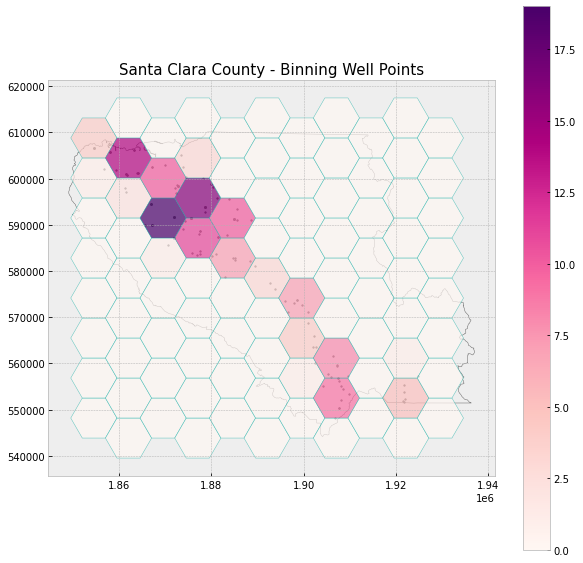

In [202]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

sc_county.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
sc_county_wells.plot(ax = ax, marker = 'o', color = 'dimgrey', markersize = 3)
sc_county_grid.plot(ax = ax, column = 'Count', cmap = 'RdPu', edgecolor = 'lightseagreen', linewidth = 0.5, alpha = 0.7, legend = True)

ax.set_title('Santa Clara County - Binning Well Points', fontdict = {'fontsize': '15'})
plt.show()

## Kernel Density Estimation

Kernel density estimation (KDE) **visualizes concentrations points or polylines**. It calculates a magnitude per unit area, providing the density estimate of features within a specified neighborhood surrounding each feature.

A kernel function is used to **fit a smooth surface to each feature**. One of the most common types of kernels is the Gaussian kernel, which is a normal density function. Other types of kernel functions can be used, and the type affects the influence of surrounding points on a location’s density estimate as the points’ distances increase from that location. These kernels’ functions vary in shapes and characteristics, such as where the function peaks, how pointed the peak is, and how fast the peak is reached with distance.

In addition to specifying a kernel, the **bandwith** can also be specified. This parameter defines **how spread out the kernel is**. A lower bandwith allows points far away from a location to affect the density estimate at that location, whereas with a higher bandwith, only close points have influence.

Individual density functions based on a specified kernel are plotted for each feature. Then, individual density function values at a location are aggregated to produce the KDE value at that location, and this is repeated across the entire point or polyline extent. The final KDE result is a **raster depicting the sum of all individual density functions**.

We will demonstrate two ways to perform kernel density estimation. The first way allows us to quickly visualize the KDE. The second way also allows us to export and save a KDE raster for additional analysis.

Tip -- we are intentionally keeping the well points beyond (but within 50 km) of the Bay Area boundaries. This provides a buffer to ensure that the KDE for wells data near the boundaries is not inadvertently influenced by these artificial county boundaries. Once KDE is run, the result can be clipped to the Bay Area boundaries (which we do in the first method).

### Method 1 - Display

This method uses `geoplot`, a high-level ploting library for spatial data that complement matplotlib.

c:\Users\gilramolete\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'clips'
  cset = contour_func(


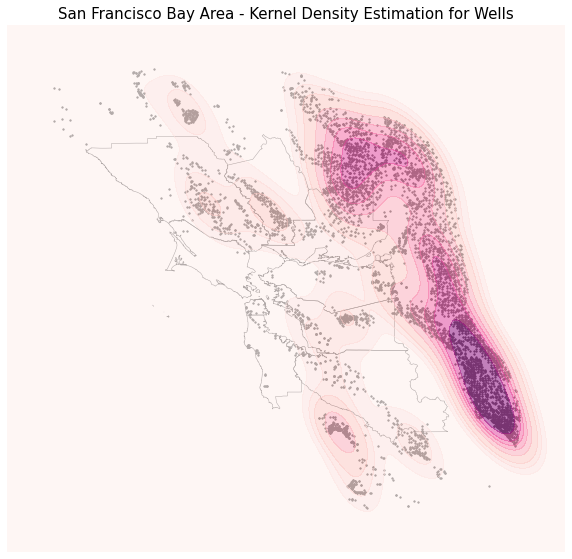

In [203]:
# Set projection to WGS 84 and reproject data
proj_wgs = 4326
counties_wgs = counties.to_crs(proj_wgs)
wells_wgs = wells.to_crs(proj_wgs)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
wells_wgs.plot(ax = ax, marker = 'o', color = 'dimgrey', markersize = 3)
gplt.kdeplot(wells_wgs, cmap = 'RdPu', shade = True, clips = counties_wgs, thresh = 0, ax = ax, alpha = 0.50)

ax.set_title('San Francisco Bay Area - Kernel Density Estimation for Wells', fontdict = {'fontsize': '15'})
plt.show()

### Method 2 - Display and export with `scikit-learn`

This method uses scikit-learn to visualize and export the KDE result. We are able to specify and change various estimator parameters. Examples include:
- Kernel type
- [Metric](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) (how distances from a location are calculated)
- [Algorithm](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms) (how to quickly identify neighboring points instead of performing time and resource intensive brute force)

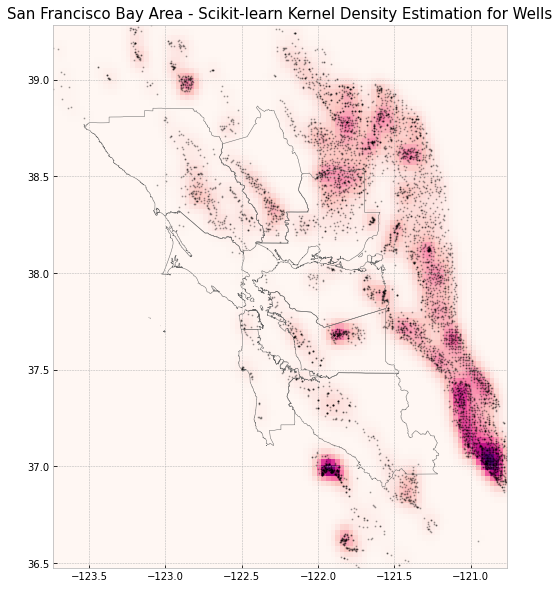

In [204]:
# Get X and Y coordinates of well points
x_sk = wells_wgs['geometry'].x
y_sk = wells_wgs['geometry'].y

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = wells_wgs.total_bounds

# Create a cell mesh grid, horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2D arrays of the coordinates values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk]).T

# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 0.04, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Fit kernel density estimator to wells coordinates
kde_sk.fit(Xtrain_sk)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

# Plot data
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.imshow(np.rot90(Z_sk), cmap = 'RdPu', extent = [min_x_sk, max_x_sk, min_y_sk, max_y_sk])
ax.plot(x_sk, y_sk, 'k.', markersize = 2, alpha = 0.25)
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
ax.set_title('San Francisco Bay Area - Scikit-learn Kernel Density Estimation for Wells', fontdict = {'fontsize': 15})
plt.show()

We can export the raster is necessary.

In [205]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    """Export and save a kernel density raster.
    """
    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
        filename,
        mode = 'w',
        driver = 'GTiff',
        height = Z_export.shape[0],
        width = Z_export.shape[1],
        count = 1,
        dtype = Z_export.dtype,
        crs = proj,
        transform = transform
    ) as new_dataset:
        new_dataset.write(Z_export, 1)

In [206]:
# Export raster
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                proj = proj_wgs, filename = os.getcwd() + '/data/bay-area-wells_kde_sklearn.tif')

# Spatial Interpolation

Interpolation is the process of **using locations with known, sampled values (of a phenomenon) to estimate the values at unknown, unsampled areas**. In this chapter, we will explore three interpolation methods: Thiessen polygons (Voronoi diagrams), k-nearest neighbors (KNN), and kriging.

We will utilize shapefiles of San Francisco Bay Area county boundaries and rainfall “values” that were “sampled” in the Bay Area. It is critical to use a ‘projected’ coordinate system when doing interpolation. If you keep your data in geographic lat lon distances will vary significantly as you move up and down in latitude… since interpolation depends on distance as a way of establishing relationships this would be a problem… a big one.

In [207]:
# County boundaries
counties = gpd.read_file(os.getcwd() + '/data/static/sf_bay_counties/sf_bay_counties.shp')

# Rainfall measurement "locations"
rainfall = gpd.read_file(os.getcwd() + '/data/static/sf_bay_rainfall/sf_bay_rainfall.shp')

# Reproject data to CA Teale Albert
proj = '+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
counties = counties.to_crs(proj)
rainfall = rainfall.to_crs(proj)

# Get X and Y coordinates of rainfall points
x_rain = rainfall['geometry'].x
y_rain = rainfall['geometry'].y

# Create list of XY coordinate pairs
coords_rain = [list(xy) for xy in zip(x_rain, y_rain)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_rain = list(rainfall['VALUE'])

# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved['constant'] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = 'constant').reset_index(drop = True)

def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''
    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
        filename,
        mode = 'w',
        driver = 'GTiff',
        height = Z.shape[0],
        width = Z.shape[1],
        count = 1,
        dtype = Z.dtype,
        crs = proj,
        transform = transform,
    ) as new_dataset:
        new_dataset.write(Z, 1)

With any model used for prediction, it is important to **assess the model fit for unobserved locations** (or the accuracy of the values predicted by the model in relation to their actual values). Thus, in order to assess the fit, we break our data into two portions, a **“training” data set used to train the model**, and a **“testing” set that remains “unseen” by the model** but can be used to assess model performance. Effectively, we can use this “unseen” testing subset to validate the model because we can compare their true values with the estimated value from the model prediction.

We will separate our rainfall dataset into two subsets: one for training and the other for testing. These subsets will be used in our KNN and kriging analyses.

In [208]:
coords_rain

[[-165954.55917454095, -55318.880026611034],
 [-175941.8262490374, -52292.08591689356],
 [-146179.80573141854, -47541.4425256839],
 [-174812.16964936187, -45597.69424294308],
 [-139391.16078040813, -53237.47081619222],
 [-179999.61226066452, -38144.901156255975],
 [-173953.8448946342, -40722.40754449321],
 [-173054.66329625837, -59411.422330613714],
 [-168910.9640469885, -53431.613135756925],
 [-188393.52553303298, -44959.43988218997],
 [-140381.0109377593, -49704.86509318231],
 [-181310.0683040523, -22692.256061228923],
 [-152198.4472444064, -47918.60483257426],
 [-158618.84105371436, -44582.30490873335],
 [-168019.34046045935, -35188.992595994845],
 [-189473.44064836827, -32391.428894823883],
 [-154963.27624929746, -45407.5283474247],
 [-167009.2616682059, -39335.68626845162],
 [-172480.632403228, -45066.15952828154],
 [-162810.60613429628, -42817.86421887763],
 [-195176.11025812797, -24824.57702047797],
 [-155151.39740535605, -49880.80250626616],
 [-150636.92317348596, -37539.828231

In [209]:
value_rain

[32,
 23,
 32,
 31,
 35,
 37,
 41,
 22,
 27,
 25,
 35,
 42,
 30,
 27,
 32,
 30,
 28,
 32,
 34,
 28,
 32,
 32,
 22,
 35,
 22,
 27,
 33,
 24,
 30,
 34,
 24,
 38,
 38,
 23,
 19,
 36,
 29,
 23,
 30,
 22,
 40,
 31,
 22,
 41,
 23,
 31,
 38,
 32,
 22,
 29,
 21,
 34,
 20,
 21,
 29,
 33,
 26,
 24,
 26,
 21,
 22,
 22,
 21,
 20,
 22,
 41,
 27,
 37,
 30,
 22,
 40,
 35,
 27,
 23,
 21,
 40,
 41,
 40,
 32,
 35,
 21,
 26,
 40,
 26,
 23,
 31,
 41,
 25,
 25,
 29,
 33,
 32,
 45,
 33,
 41,
 23,
 20,
 29,
 32,
 24,
 42,
 61,
 48,
 47,
 60,
 65,
 44,
 54,
 60,
 67,
 59,
 65,
 56,
 57,
 59,
 60,
 52,
 62,
 64,
 49,
 68,
 59,
 58,
 67,
 49,
 66,
 67,
 46,
 59,
 58,
 59,
 62,
 55,
 54,
 61,
 53,
 75,
 53,
 70,
 66,
 63,
 44,
 57,
 63,
 54,
 45,
 62,
 59,
 42,
 39,
 50,
 39,
 44,
 47,
 57,
 50,
 50,
 48,
 54,
 44,
 45,
 35,
 39,
 58,
 32,
 62,
 48,
 41,
 48,
 51,
 52,
 55,
 46,
 50,
 59,
 50,
 63,
 57,
 41,
 52,
 51,
 46,
 43,
 61,
 55,
 58,
 67,
 65,
 48,
 48,
 58,
 34,
 67,
 44,
 32,
 39,
 40,
 58,
 56,
 51,


In [210]:
coords_rain_df = pd.DataFrame(coords_rain)
value_rain_df = pd.DataFrame(value_rain)

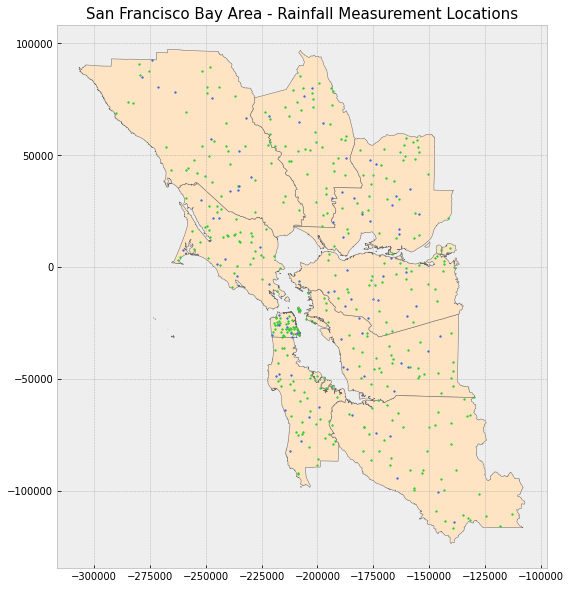

In [211]:
# Split data into testing and training sets
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_rain, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj)
rain_train_gdf['Actual_Value'] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)
rain_test_gdf['Actual_Value'] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

# Plot data
fig, ax = plt.subplots(1, 1, figsize= (10, 10))

counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgrey')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)

ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations', fontdict = {'fontsize': '15'})
plt.show()

In the map above, the green and blue points are the rainfall points that we loaded separated into the training set and testing set, respectively.

## Thiessen Polygons (Voronoi Diagrams)

Thiessen polygons (also known as Voronoi diagrams) polygons allow us to **perform nearest neighbor interpolation**, which is perhaps the most basic type of interpolation. Thiessen polygons are constructed around each sampled point so all the space within a specific polygon is closest in distance to that sampled point (as compared to other sampled points). Then, to perform nearest neighbor interpolation, all that space is assigned the value of that sampled point.

We can use the **`scipy`** package to create Thiessen polygons. After running the `Voronoi()` function, we can use the `vertices` attribute to get a list of vertices, which we can subsequently use to generate polygons.

Attention -- When creating Thiessen polygons, the sample points toward the edges of the point shapefile’s extent will have infinite Voronoi regions, because not all sides of these edge points have adjacent sample points that would constrain the regions. Consequently, these infinite regions will not be exported. To mitigate this issue, we can **create dummy points well beyond the extent of our datasets**, which will create finite Voronoi regions for all of our actual sample points. Then, we can clip the regions to our extent shapefile (creating dummy points far away from our actual sample points will ensure the dummy points and their infinite Voronoi regions do not interfere with the sample points and their associated finite Voronoi regions after all regions are clipped).

In [212]:
# Extend extent of counties feature by using buffer
counties_buffer = counties.buffer(100000)

# Get extent of buffered input feature
min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = counties_buffer.total_bounds

# Use extent to create dummy points and add them to list of coordinates
coords_tp = coords_rain_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, min_y_cty_tp]]

# Compute Voronoi diagram
tp = Voronoi(coords_tp)

# Create empty list of hold Voronoi diagrams
tp_poly_list = []

# Create a polygon for each region
# 'regions' attribute provides a list of indices of the vertices (in the 'vertices' attribute) that make up the region
for region in tp.regions:
    # Ignore region if -1 is in the list (based on documentation)
    if -1 in region:
        # Return to top of loop
        continue
    
    # Otherwise, pass
    else:
        pass

    # Check that region list has values in it
    if len(region) != 0:
        # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # Append polygon to list
        tp_poly_list.append(tp_poly_region)
    
    # If no values, return to top of loop
    else:
        continue

# Create GeoDataFrame from list of polygon regions
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = proj)

# Clip polygons regions to the counties boundary
tp_polys_clipped = gpd.clip(tp_polys, counties_dissolved)

# A spatial join can be conducted to assign the rainfall training values to its associated Thiessen polygon
# If rainfall point within the polygon, assign that rainfall value to the polygon
tp_polys_clipped_values = gpd.sjoin(rain_train_gdf, tp_polys_clipped, how = 'right', op = 'within')

# Drop un-needed column
tp_polys_clipped_values = tp_polys_clipped_values.drop('index_left', axis = 1)

# Remove column
tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": 'VALUE_Thiessen'})

# Display head of attribute table
print('Attribute Table: Thiessen Polygon Interpolated Values')
display(tp_polys_clipped_values.head())

Attribute Table: Thiessen Polygon Interpolated Values


c:\Users\gilramolete\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


VALUE_Thiessen                                           geometry
158              22  POLYGON ((-154063.004 -39520.674, -159630.237 ...
311              38  POLYGON ((-182157.502 -32191.949, -182015.585 ...
313              32  POLYGON ((-173404.155 -34004.190, -173707.795 ...
303              32  POLYGON ((-169047.468 -27467.570, -163247.997 ...
314              40  POLYGON ((-182015.585 -29550.249, -182505.388 ...

A second spatial join can be conducted to assign those values from the Thiessen polygons to the points from the testing dataset (only if a test point falls within a polygon). We can subsequently get the out-of-sample r-squared value, which is calculated by using the data points that the model did not use (the testing dataset) and comparing the testing dataset’s actual values to the values as predicted by the model.

In [213]:
# If test point is within a polygon, assign that polygon's value to the test point
rain_test_pred_tp = gpd.sjoin(rain_test_gdf, tp_polys_clipped_values, how = 'left', op = 'within')

# Drop un-needed column
rain_test_pred_tp = rain_test_pred_tp.drop('index_right', axis = 1)

# Rename column
rain_test_pred_tp = rain_test_pred_tp.rename(columns = {"Actual_Value": 'VALUE_Actual', 'VALUE_Thiessen': 'VALUE_Predict'})

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_pred_tp.VALUE_Actual, rain_test_pred_tp.VALUE_Predict)
print('Thiessen polygon out-of-sample r-squared: ', round(out_r_squared_tp, 2))

# Display attribute table
print('\nAttribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method')
display(rain_test_pred_tp.head())

c:\Users\gilramolete\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Thiessen polygon out-of-sample r-squared:  0.89

Attribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method


geometry  VALUE_Actual  VALUE_Predict
0   POINT (-229633.109 40063.957)            56             62
1   POINT (-273849.549 92453.790)            73             91
2    POINT (-244810.053 1296.591)            62             65
3  POINT (-186774.244 -45693.437)            24             24
4   POINT (-235201.599 35975.741)            45             46

Plotting the data, we see that each polygon has one green training point (and vice-versa). All space within one polygon is closest to the known training point (green dot) within the polygon. The testing points (blue dots) are assigned the value of the Thiessen polygon in which it falls.

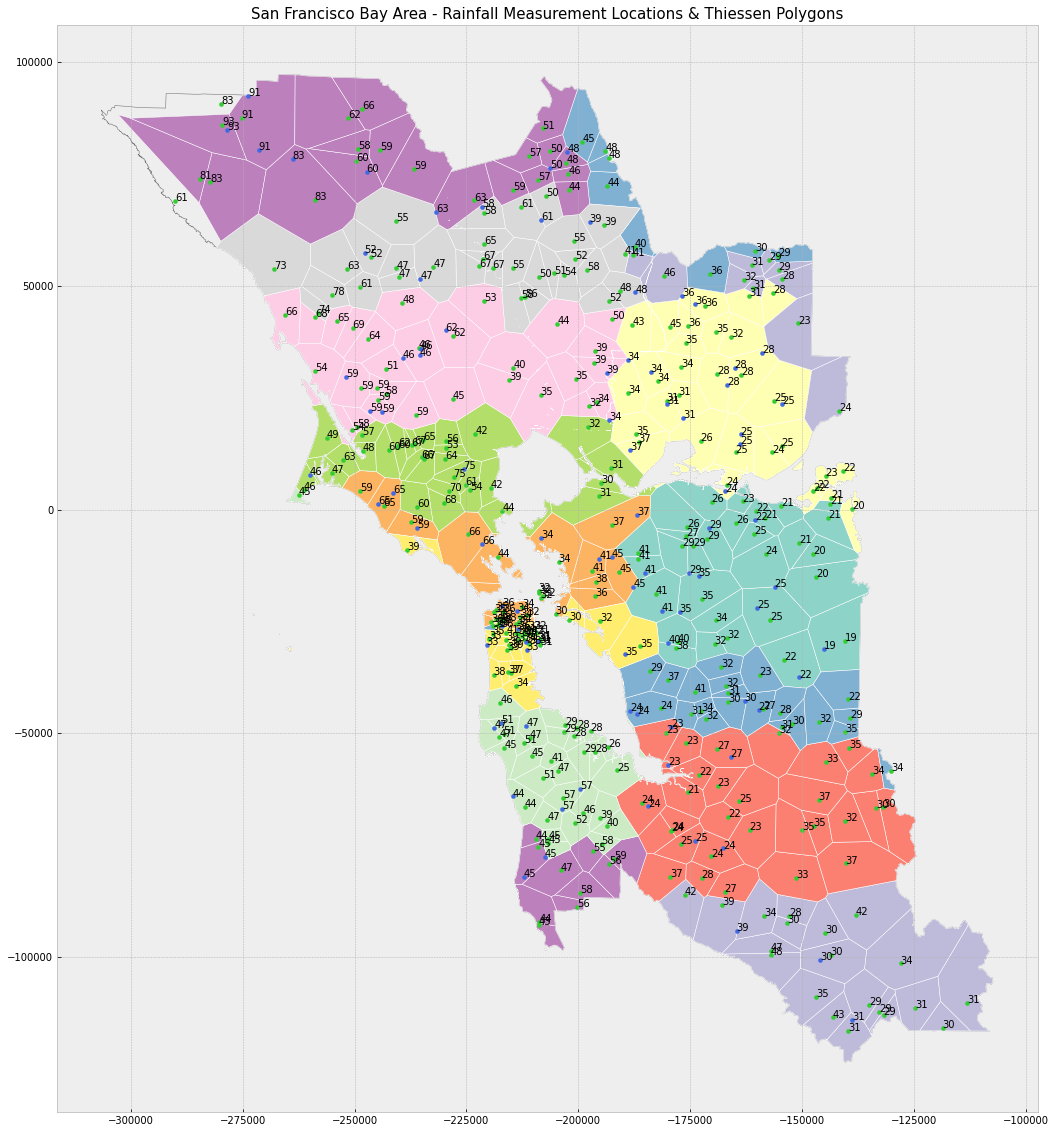

In [214]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))

counties_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
tp_polys_clipped.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 16)
rain_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 16)

# Iterate through each rainfall train point to add a label with its value to the plot
for index, row in rain_train_gdf.iterrows():
    plt.annotate(row.Actual_Value, (row.geometry.x, row.geometry.y))

# Iterate through each rainfall test point to add a label with its value to the plot
for index, row in rain_test_pred_tp.iterrows():
    plt.annotate(row.VALUE_Predict, (row.geometry.x, row.geometry.y))

ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations & Thiessen Polygons', fontdict = {'fontsize': '15'})
plt.show()

In addition to `vertices`, there are a few other attributes we can call if we want to further explore the polygons. These attributes will provide actual values (e.g., vertices) or provide the indices for querying other attributes.

In the example below, we demonstrate how to extract the value of one of the Thiessen polygons at a new location for which we want a predicted value. We use the `point_region` attribute to provide the index of a point’s Voronoi region, and we use that index to get the region in `regions`. That provides indices of the vertices that make up the polygon, which we use to get the appropriate values in `vertices`.

In [215]:
# Set index for feature of interest
feature_index_one = 5

# Get a Voronoi polygon for one feature
    # 'point_region' attribute provides the index of the Voronoi region belonging to a specified point
    # Can use the index to call the appropriate element in the 'regions' attribute
tp_poly_region_one = Polygon(tp.vertices[tp.regions[tp.point_region[feature_index_one]]])

# Create GeoDataFrame for polygon
tp_poly_region_one = gpd.GeoDataFrame([tp_poly_region_one], columns = ['geometry'], crs = proj)

# Clip polygon to county boundary
tp_poly_region_one = gpd.clip(tp_poly_region_one, counties_dissolved)

# Get the equivalent feature from the rainfall dataset
rain_one = rain_train_gdf.iloc[[feature_index_one]]

# Add the rainfall value to the polygon attribute table
tp_poly_region_one['VALUE_Predict'] = rain_one['Actual_Value'].values

# Display attribute table
print('Attribute Table: Thiessen Polygon Interpolated Value')
display(tp_poly_region_one)

Attribute Table: Thiessen Polygon Interpolated Value


geometry  VALUE_Predict
0  POLYGON ((-182157.502 -32191.949, -182015.585 ...             38

Here's how that one Thiessen polygon looks.

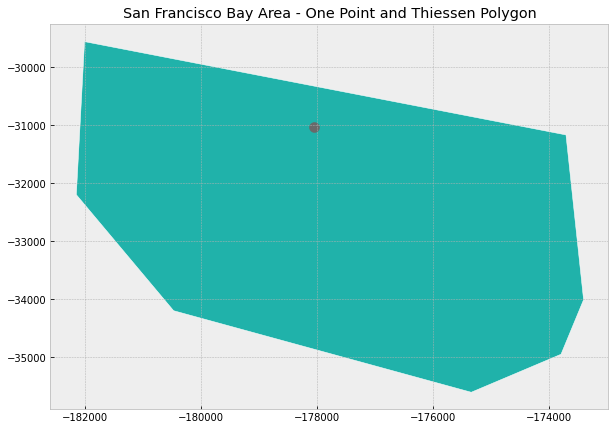

In [216]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

tp_poly_region_one.plot(ax = ax, color = 'lightseagreen', edgecolor = 'white', linewidth = 0.5)
rain_one.plot(ax = ax, marker = 'o', color = 'dimgrey', markersize = 100)

plt.title('San Francisco Bay Area - One Point and Thiessen Polygon')
plt.show()

## K-Nearest Neighbors

KNN (also stylized as kNN) is a neighbor-based learning method that can be used for interpolation. Unlike the Thiessen polygons method, KNN looks for a specified number K of sampled points closest to an unknown point. The `K` known points can be used to predict the value (discrete or continuous) of the unknown point.

We can use the scikit-learn module to perform KNN analysis.

In [224]:
# Set number of neighbors to look for
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = 'distance')

# Fit regressor to data
knn_regressor.fit(coords_rain_train, value_rain_train)

KNeighborsRegressor(weights='distance')

Now that we have created the KNN model, we can get the in-sample r-squared value. An in-sample statistic, as suggested by its name, is calculated by using tehd ata that were used to build the model (the 'training' dataset).

In [225]:
# Generate in-sample R^2
in_r_squared_knn = knn_regressor.score(pd.DataFrame(coords_rain_train), pd.DataFrame(value_rain_train))
print('KNN in-sample r-squared: ', round(in_r_squared_knn, 5))

KNN in-sample r-squared:  1.0


Here, the in-sample r-squared value is 100% because KNN is a “exact interpolator.” For exact interpolators, estimated values for known points are exactly equal to actual values. Other methods like Kriging, shown below, are inexact interpolators. For inexact interpolators, estimated values for known points are not exactly equal to actual values. Here’s a visual of inexact versus exact interpolators.

Similarily, we can also get the out-of-sample r-squared value and compare the test dataset’s actual values to the values as predicted by the model.

In [226]:
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(pd.DataFrame(coords_rain_test), pd.DataFrame(value_rain_test))
print('KNN out-of-sample r-squared: ', round(out_r_squared_knn, 5))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(pd.DataFrame(coords_rain_test))

# Create dictionary holding the actual and predicted values
predict_dict_knn = {
    'Coordinate_Pair': coords_rain_test,
    'VALUE_Actual': value_rain_test,
    'VALUE_Predict': coords_rain_test_predict_knn
}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print('\nAttribute Table: Testing Set Interpolated Values - KNN Method')
display(predict_df_knn.head())

KNN out-of-sample r-squared:  0.92754

Attribute Table: Testing Set Interpolated Values - KNN Method


Coordinate_Pair  VALUE_Actual  VALUE_Predict
0    [-229633.10884980168, 40063.95711899595]            56      55.827991
1     [-273849.5486325992, 92453.78988359217]            73      87.640074
2   [-244810.05263254736, 1296.5909492345527]            62      61.295546
3  [-186774.24351374304, -45693.437096342444]            24      26.993616
4   [-235201.59850455774, 35975.740596358664]            45      47.893993

If you are just interested in identifying the k nearest neighbors (no interpolation), use the `NearestNeighbors()` function.

## Kriging

Kriging is a type of interpolation that uses a **semivariogram**, which measures **spatial autocorrelation** (how similar close points are in value and how this similarity changes as distance between points increases). Thus, the semivariogram determines **how much influence a known point has on an unknown point as the distance between the known point and the unknown point increase**s. In other words, the weight of a known point on an unknown point decreases with increasing distance, and the semivariogram determines how quickly that weight tapers with increasing distance. 1, 4

For more information, see this [ArcGIS help guide on kriging](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm).

Two Python packages that can be used for kriging include `Click to hide` and `pykrige`. The former package works best when the input data has a WGS 84 projection, so we will begin by reprojecting all of our data to that coordinate system.

In [234]:
# Set projection to WGS 84 and reproject data
proj_wgs = 4326
counties_wgs = counties.to_crs(proj_wgs)
rainfall_wgs = rainfall.to_crs(proj_wgs)
rain_train_gdf_wgs = rain_train_gdf.to_crs(proj_wgs)
rain_test_gdf_wgs = rain_test_gdf.to_crs(proj_wgs)

# Get X and Y coordinates of rainfall points
x_rain_wgs = rainfall_wgs['geometry'].x
y_rain_wgs = rainfall_wgs['geometry'].y

# Create list of XY coordinate pairs
coords_rain_train_wgs = [list(xy) for xy in zip(rain_train_gdf_wgs['geometry'].x, rain_train_gdf_wgs['geometry'].y)]
coords_rain_test_wgs = [list(xy) for xy in zip(rain_test_gdf_wgs['geometry'].x, rain_test_gdf_wgs['geometry'].y)]

# Get minimum and maximum coordinate values of rainfall points
min_x_rain_wgs, min_y_rain_wgs, max_x_rain_wgs, max_y_rain_wgs = rain_train_gdf_wgs.total_bounds

### Method 1 - Using `PyKrige`

The pykrige module offers ordinary and universal kriging. It also supports various variogram models in addition to Gaussian.

PyKrige Kriging out-of-sample r-squared:  0.99148

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


geometry  Actual_Value  VALUE_Predict
0   POINT (-229633.109 40063.957)            56      55.089672
2    POINT (-244810.053 1296.591)            62      61.013490
3  POINT (-186774.244 -45693.437)            24      24.045623
4   POINT (-235201.599 35975.741)            45      48.460338
5   POINT (-187291.104 48551.934)            48      46.504630

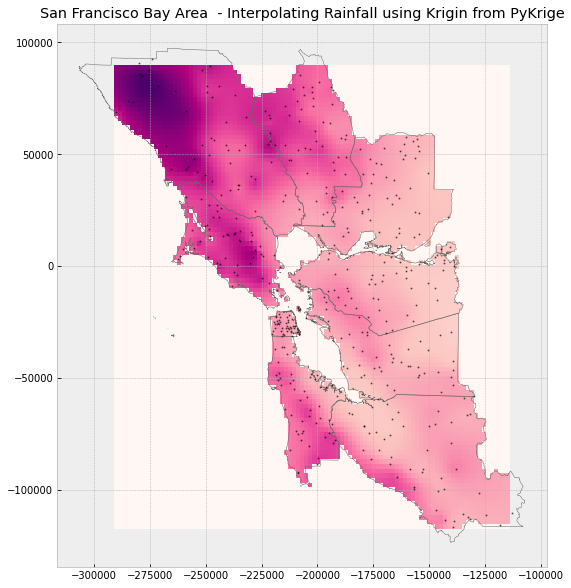

In [233]:
# Create a 100x100 grid, horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_rain, max_x_rain, 100)
YY_pk_krig = np.linspace(min_y_rain, max_y_rain, 100)

# Generate ordinary kriging object
OK = OrdinaryKriging(
   np.array(x_rain),
   np.array(y_rain),
   value_rain,
   variogram_model = 'linear',
   verbose = False,
   enable_plotting = False,
   coordinates_type = 'euclidean' 
)

# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute('grid', XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                min_x = min_x_rain, max_x = max_x_rain, min_y = min_y_rain, max_y = max_y_rain,
                proj = proj, filename = os.getcwd() + '/data/e_bay-area-rain_pk_kriging.tif')

# Open raster
raster_pk = rasterio.open(os.getcwd() + '/data/e_bay-area-rain_pk_kriging.tif')

# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {
    'Attribute': ['name1'],
    'geometry': poly_shapely
}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
rain_test_gdf_pk_krig = rain_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
rain_test_gdf_pk_krig = rain_test_gdf_pk_krig[rain_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_rain_test_pk_krig = [list(xy) for xy in zip(rain_test_gdf_pk_krig['geometry'].x, rain_test_gdf_pk_krig['geometry'].y)]

# Extract raster value at each test point and add values to the GeoDataFrame
rain_test_gdf_pk_krig['VALUE_Predict'] = [x[0] for x in raster_pk.sample(coords_rain_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_gdf_pk_krig.Actual_Value, rain_test_gdf_pk_krig.VALUE_Predict)
print('PyKrige Kriging out-of-sample r-squared: ', round(out_r_squared_tp, 5))

# Display attribute table
print('\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method')
display(rain_test_gdf_pk_krig.head())

# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)

# Plot data
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = 'RdPu')
ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
plt.gca().invert_yaxis()

plt.title('San Francisco Bay Area  - Interpolating Rainfall using Kriging from PyKrige')
plt.show()

### Method 2 - Using `scikit-learn`

Kriging can be performed using Gaussian processes from the **`scikit-learn`** module (Gaussian processes is essentially equivalent to kriging). Various kernels for Gaussian processes can be specified. We will continue to use the training and testing datasets created from our KNN analysis.

In [235]:
# Create a 100x 100 mesh grid, horizontal and vertical cell counts should be the same
XX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]

# Create 2D array of the coordinates (paired) of each cell in the mesh grid
positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

# Generate Gaussian Process model (can change parameters as desired)
gp = GaussianProcessRegressor(n_restarts_optimizer = 10)

# Fit kernel density estimator to coordinates and values
gp.fit(coords_rain_train_wgs, value_rain_train)

# Evaluate the model on coordinate pairs
Z_sk_krig = gp.predict(positions_sk_krig)

# Reshape the data to fit mesh grid
Z_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)

In [236]:
# Generate in-sample R^2
in_r_squared_sk_krig = gp.score(pd.DataFrame(coords_rain_train_wgs), pd.DataFrame(value_rain_train))
print('Scikit-learn Kriging in-sample r-squared: ', round(in_r_squared_sk_krig, 5))

# Generate out-of-sample R^2
out_r_squared_sk_krig = gp.score(pd.DataFrame(coords_rain_test_wgs), pd.DataFrame(value_rain_test))
print('Scikit-learn Kriging out-of-sample r-squared: ', round(out_r_squared_sk_krig, 5))

# Predict values for testing dataset
coords_rain_test_predict_sk_krig = gp.predict(pd.DataFrame(coords_rain_test_wgs))

# Create dictionary holding the actual and predicted values
predict_dict_sk_krig = {
    'Coordinate_Pair': coords_rain_test_wgs,
    'VALUE_Actual': value_rain_test,
    'VALUE_Predict': coords_rain_test_predict_sk_krig
}

# Create dataframe from dictionary
predict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)

# Display attribute table
print('\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method')
display(predict_df_sk_krig.head())

Scikit-learn Kriging in-sample r-squared:  0.92259
Scikit-learn Kriging out-of-sample r-squared:  0.91198

Attribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method


Coordinate_Pair  VALUE_Actual  VALUE_Predict
0   [-122.63103459126236, 38.34810139689807]            56      47.770447
1  [-123.15728724047081, 38.807051950584196]            73      85.752502
2  [-122.79175185575068, 37.995603540623385]            62      55.796753
3   [-122.1182117956604, 37.586560201281245]            24      25.466400
4   [-122.69347157306474, 38.30993280658024]            45      51.101929

Looks good! Let's export the raster.

In [238]:
# Flip array vertically and rotate 270 degrees
Z_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)


# Export raster
export_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,
                min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,
                proj = proj_wgs, filename = os.getcwd() + '/data/e_bay-area-rain_sk_kriging.tif')

The resulting raster should be clipped. Because the resulting raster covers the extent of the points in a bounding box fashion, the raster in this case covers areas that are not within the counties boundaries (such as in the ocean) where we do not have sample points. Thus, there will be interpolated values in those areas that might not make sense.

Finally, we import the raster, mask it to the counties boundaries, and plot the data.

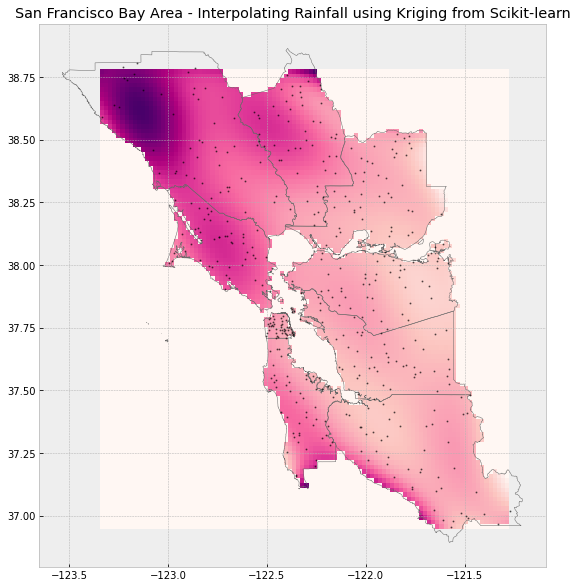

In [239]:
# Open raster
raster_sk = rasterio.open(os.getcwd() + '/data/e_bay-area-rain_sk_kriging.tif')

# Mask raster to counties shape
out_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)

# Plot data
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
show(out_image_sk, ax = ax, transform = out_transform_sk, cmap = 'RdPu')
ax.plot(x_rain_wgs, y_rain_wgs, 'k.', markersize = 2, alpha = 0.50)
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgrey')
plt.gca().invert_yaxis()

plt.title('San Francisco Bay Area - Interpolating Rainfall using Kriging from Scikit-learn')
plt.show()